In [1]:
## circstats
def len2(x):
	if type(x) is not type([]):
		if type(x) is not type(array([])):
			return -1
	return len(x)

def phase2(x):
	if not np.isnan(x):
		return phase(x)
	return nan
    
def circdist(angles1,angles2):
    ''' calculates circular distance of angles [rad]'''
    if len2(angles2) < 0:
        if len2(angles1) > 0:
            angles2 = [angles2]*len(angles1)
        else:
            angles2 = [angles2]
            angles1 = [angles1]
        if len2(angles1) < 0:
            angles1 = [angles1]*len(angles2)
    return array(list(map(lambda a1,a2: phase2(np.exp(1j*a1)/np.exp(1j*a2)), angles1,angles2)))

### read in files

In [2]:
def read_baseline(filename, mode):
    ''' 
    reads in accuracies/std for 1000x mixed labels per timepoint for r² and MSE evaluation
    INPUT:
        filename:       name of file containing 1000x croxxvalidation on mixed labels
    OUTPUT:
        r2_baseline:    previous accuracy, std and current accuracy, std for the mixed labels R² evaluation
        mse_baseline:   previous accuracy, std and current accuracy, std for the mse evaluation turned into MSE accuracy[%]
    
    '''
    file = io.open(filename, "r")
    contents = file.readlines()
    
    values = [eval(contents[i]) for i in range(len(contents))]

    if mode == 'r2':
        r2_baseline = {'acc_prev':values[0], 'std_prev':values[1], 'acc_curr':values[2], 'std_curr':values[3]}
        return r2_baseline
        
    elif mode =='MSE':
        #values[4] = 100-np.array(values[4])*100/circdist(0, np.pi)[0]**2#np.pi
        #values[5] = np.array(values[5])*100
        #values[6] = 100-np.array(values[6])*100/circdist(0, np.pi)[0]**2#np.pi
        #values[7] = np.array(values[7])*100
        mse_baseline = {'acc_prev':values[4], 'std_prev':values[5], 'acc_curr':values[6], 'std_curr':values[7]}
        return mse_baseline

    return print('ERROR: mode must either be r2 or MSE.')


In [3]:
def read_reactivations_AllMonkeys(filename, df, mode):
    ''' 
    reads in prediction error of target, prediction from leave-1-out crossval from delay-decoder
    during the reactivation period (5 sessions)
    INPUT:
        filename:       name of file containing decoding accuracies .h5 file
                        (bins=50ms)  
        df:             dataframe containing minimum monkey, session information
    OUTPUT:
        acc:            prediction error [monkey,session x trials x reactivation time]
    
    '''
    hf = h5py.File(filename, 'r')
    
    if mode=='single':
        acc = {'Sa':[], 'Pe':[], 'Wa':[]}
        borders = {'Sa':[], 'Pe':[], 'Wa':[]}
        print(hf.keys())
        for mono in ['Sa', 'Pe', 'Wa']:
            for sess in range(max(df.loc[df.monkey==mono].session)+1):
                n1 = hf.get(mono+str(sess))
                print(n1)
                acc[mono].append(np.array(n1))

                # get borders of time period endings
                n2 = hf.get(mono+str(sess)+'_borders')
                #print(n1)
                borders[mono].append(np.array(n2))
                
    
    elif mode=='hemispheres':
        acc = {'Sa_leftIpsi':[], 'Pe_leftIpsi':[], 'Wa_leftIpsi':[],\
               'Sa_leftContra':[], 'Pe_leftContra':[], 'Wa_leftContra':[],\
              'Sa_rightIpsi':[], 'Pe_rightIpsi':[], 'Wa_rightIpsi':[],\
               'Sa_rightContra':[], 'Pe_rightContra':[], 'Wa_rightContra':[]}
        borders = {'Sa':[], 'Pe':[], 'Wa':[]}
        print(hf.keys())
        for mono in ['Sa', 'Pe', 'Wa']:
            for sess in range(max(df.loc[df.monkey==mono].session)+1):
                for hemi in ['_leftIpsi', '_leftContra', '_rightIpsi', '_rightContra']:
                    n1 = hf.get(mono+str(sess)+hemi)
                    print(n1)
                    acc[mono+hemi].append(np.array(n1))

                    # get borders of time period endings
                    n2 = hf.get(mono+str(sess)+'_borders')
                #print(n1)
                borders[mono].append(np.array(n2))
    
    else:
        print('mode needs to be either: single or hemispheres.')
    hf.close()

    return acc, borders

### decoders

In [4]:
# y is fixed only X changes based on time in trial
def decoder_delayVSresponse(dataframe,borders_full):
    mode='MSE'

    y = dataframe['target_prev']-np.pi# target_prev # response_prev

    # train in previous trial delay (mean over individual delay length )
    X_delay = pd.DataFrame([np.mean(dataframe['bin_sp_prev'][n][borders_full[2]:borders_full[3]], axis=0) for n in range(len(dataframe['bin_sp_prev']))])
    # train in previous trial response (ITI=borders[6:7], reward= borders[5:6])
    X_response = pd.DataFrame([np.mean(dataframe['bin_sp_prev'][n][borders_full[6]:borders_full[7]],axis=0) for n in range(len(dataframe['bin_sp_prev']))])

    acc_bias_prev_delay = []
    std_bias_prev_delay = []
    acc_bias_curr_delay = []
    std_bias_curr_delay = []
    acc_bias_prev_response=[]
    std_bias_prev_response=[]
    acc_bias_curr_response=[]
    std_bias_curr_response=[]
    for delta_t_train in range(len(dataframe['bin_sp_prev'][dataframe['bin_sp_prev'].index[0]])):# for each period ['targ_on', 'targ_off', 'go_cue', 'saccade', 'reward']
        # create training dataset: columns=neurons, rows=trials within specified time bin(in period)
        X_prev = pd.DataFrame([dataframe['bin_sp_prev'][n][delta_t_train] for n in range(len(dataframe['bin_sp_prev']))])
        X_curr = pd.DataFrame([dataframe['bin_sp_curr'][n][delta_t_train] for n in range(len(dataframe['bin_sp_curr']))])
        # Crossvalidation
        acc_crosscorr_prev_delay=[]
        acc_crosscorr_curr_delay=[]
        acc_crosscorr_prev_response=[]
        acc_crosscorr_curr_response=[] 
        for k in range(0,10):# k=10 as in Barbosa2020
            #train test split
            rand_state = randint(0,10000)# to get the same split for previous, current
            X_train_delay, X_i, y_train, y_i = train_test_split(X_delay, y, test_size = 0.20, random_state=rand_state)# train in slow loop
            X_train_response, X_i, y_train, y_i = train_test_split(X_response, y, test_size = 0.20, random_state=rand_state)# train in slow loop
            X_i, X_test_prev, y_i, y_test = train_test_split(X_prev, y, test_size = 0.20, random_state=rand_state)# test in fast loop
            X_i, X_test_curr, y_i, y_test = train_test_split(X_curr, y, test_size = 0.20, random_state=rand_state)# test in fast loop

            # determine labels (sine, cosine)
            #assert (y_train_delay == y_train_response).all()
            y_train_cos = np.cos(y_train)
            y_train_sin = np.sin(y_train)
            #y_test_cos = np.cos(y_test)

            # make linear regression fit for sine/cosine for prev/current trial
            model_d_cos = LinearRegression().fit(X_train_delay, y_train_cos)
            model_d_sin = LinearRegression().fit(X_train_delay, y_train_sin)
            model_r_cos = LinearRegression().fit(X_train_response, y_train_cos)
            model_r_sin = LinearRegression().fit(X_train_response, y_train_sin)

            # make predictions of models
            preds_prev_d_cos = model_d_cos.predict(X_test_prev)
            preds_prev_d_sin = model_d_sin.predict(X_test_prev)
            preds_curr_d_cos = model_d_cos.predict(X_test_curr)
            preds_curr_d_sin = model_d_sin.predict(X_test_curr)
            preds_prev_r_cos = model_r_cos.predict(X_test_prev)
            preds_prev_r_sin = model_r_sin.predict(X_test_prev)
            preds_curr_r_cos = model_r_cos.predict(X_test_curr)
            preds_curr_r_sin = model_r_sin.predict(X_test_curr)

            preds_d_prev = [math.atan2(preds_prev_d_sin[n],preds_prev_d_cos[n]) for n in range(len(preds_prev_d_sin))]
            preds_d_curr = [math.atan2(preds_curr_d_sin[n],preds_curr_d_cos[n]) for n in range(len(preds_curr_d_sin))]
            preds_r_prev = [math.atan2(preds_prev_r_sin[n],preds_prev_r_cos[n]) for n in range(len(preds_prev_r_sin))]
            preds_r_curr = [math.atan2(preds_curr_r_sin[n],preds_curr_r_cos[n]) for n in range(len(preds_curr_r_sin))]

            # R squared value
            if mode == 'r2':
                acc_crosscorr_prev_delay.append(metrics.r2_score(preds_d_prev, y_test.values))
                acc_crosscorr_curr_delay.append(metrics.r2_score(preds_d_curr, y_test.values))
                acc_crosscorr_prev_response.append(metrics.r2_score(preds_r_prev, y_test.values))
                acc_crosscorr_curr_response.append(metrics.r2_score(preds_r_curr, y_test.values))
            elif mode == 'MSE':
                #acc_crosscorr_prev_delay.append(np.mean((circdist(preds_d_prev, y_test.values)**2)))
                #acc_crosscorr_curr_delay.append(np.mean((circdist(preds_d_curr, y_test.values)**2)))
                #acc_crosscorr_prev_response.append(np.mean((circdist(preds_r_prev, y_test.values)**2)))
                #acc_crosscorr_curr_response.append(np.mean((circdist(preds_r_curr, y_test.values)**2)))
                acc_crosscorr_prev_delay.append(np.mean(abs(circdist(preds_d_prev, y_test.values))))
                acc_crosscorr_curr_delay.append(np.mean(abs(circdist(preds_d_curr, y_test.values))))
                acc_crosscorr_prev_response.append(np.mean(abs(circdist(preds_r_prev, y_test.values))))
                acc_crosscorr_curr_response.append(np.mean(abs(circdist(preds_r_curr, y_test.values))))
            else:
                print('Mode needs to be either:\n'+'r2 for evaluation with R² metric \n'+\
                          'or\nMSE for evaluation with mean-squared error.')
        acc_bias_prev_delay.append(np.mean(acc_crosscorr_prev_delay))
        std_bias_prev_delay.append(np.std(acc_crosscorr_prev_delay))
        acc_bias_curr_delay.append(np.mean(acc_crosscorr_curr_delay))
        std_bias_curr_delay.append(np.std(acc_crosscorr_curr_delay))

        acc_bias_prev_response.append(np.mean(acc_crosscorr_prev_response))
        std_bias_prev_response.append(np.std(acc_crosscorr_prev_response))
        acc_bias_curr_response.append(np.mean(acc_crosscorr_curr_response))
        std_bias_curr_response.append(np.std(acc_crosscorr_curr_response))
        
    return acc_bias_prev_delay,std_bias_prev_delay,acc_bias_curr_delay,std_bias_curr_delay,\
acc_bias_prev_response,std_bias_prev_response,acc_bias_curr_response,std_bias_curr_response


In [5]:
def decode_continuous_leave1out_reactivations(dataframe,y,borders_full,mode):
    '''Only decode during reactivation to check strength of serial dependence for trials
    INPUT:      dataframe = serial dependence dataframe
                y = target/response position per trial in rad [-np.pi,np.pi]
                borders_full = borders of time periods 
                mode = MSE, r² method of evaluation
    OUTPUT:     acc_curr = array of circular distance between prediction, target for time x trial
    '''
    # y is fixed only X changes based on time in trial

    acc = []
    std = []
    
    # use delay decoder
    X_delay = pd.DataFrame([np.mean(dataframe['bin_sp_prev'][n][borders_full[2]:borders_full[3]], axis=0) for n in range(len(dataframe['bin_sp_prev']))])
    
    # timing in 250ms before current stimulus start until current target start
    timing = np.append(np.arange(borders_full[7], borders_full[8]), np.arange(0,borders_full[2]))
    for delta_t_train in timing:# for trial start to target on, current trial
        # create training dataset: columns=neurons, rows=trials for previous/current trials
        if delta_t_train >= borders_full[7]:
            X_prev = pd.DataFrame([dataframe['bin_sp_prev'][n][delta_t_train] for n in dataframe['bin_sp_prev'].index])
            # Crossvalidation
            acc_crosscorr=[]
                
            loo = LeaveOneOut()
            for train_idx, test_idx in loo.split(X_prev):
                X_train_prev, X_test_prev = X_delay.loc[train_idx], X_prev.loc[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]

                # determine labels (sine, cosine)
                y_train_cos = np.cos(y_train)
                y_train_sin = np.sin(y_train)

                # create model
                model_prev_cos = LinearRegression().fit(X_train_prev, y_train_cos)
                model_prev_sin = LinearRegression().fit(X_train_prev, y_train_sin)  

                # make predictions
                preds_prev_cos = model_prev_cos.predict(X_test_prev)
                preds_prev_sin = model_prev_sin.predict(X_test_prev)

                preds_prev = [math.atan2(preds_prev_sin[n],preds_prev_cos[n]) for n in range(len(preds_prev_sin))]

                # test correctness of predictions
                if mode == 'r2':
                    acc_crosscorr.append(metrics.r2_score(preds_curr, y_test))
                elif mode == 'MSE':
                    acc_crosscorr.append(circdist(preds_prev, y_test))
                else:
                    print('Mode needs to be either:\n'+'r2 for evaluation with R² metric \n'+\
                                  'or\nMSE for evaluation with mean-squared error.')
                    return
                
        else:
            X_curr = pd.DataFrame([dataframe['bin_sp_curr'][n][delta_t_train] for n in dataframe['bin_sp_curr'].index])
        
            # Crossvalidation
            acc_crosscorr=[]
        
            loo = LeaveOneOut()
            for train_idx, test_idx in loo.split(X_prev): # for start of trial only decode during current trial for reactivations
                X_train_curr, X_test_curr = X_delay.loc[train_idx], X_curr.loc[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]

                # determine labels (sine, cosine)
                y_train_cos = np.cos(y_train)
                y_train_sin = np.sin(y_train)

                # make linear regression fit for sine/cosine for prev/current trial
                model_curr_cos = LinearRegression().fit(X_train_curr, y_train_cos)
                model_curr_sin = LinearRegression().fit(X_train_curr, y_train_sin)

                # make predictions of models
                preds_curr_cos = model_curr_cos.predict(X_test_curr)
                preds_curr_sin = model_curr_sin.predict(X_test_curr)

                preds_curr = [math.atan2(preds_curr_sin[n],preds_curr_cos[n]) for n in range(len(preds_curr_sin))]

                # R squared value
                if mode == 'r2':
                    acc_crosscorr.append(metrics.r2_score(preds_curr, y_test))
                elif mode == 'MSE':
                    #acc_crosscorr_prev.append(np.mean(abs(circdist(preds_prev, y_test))))
                    #acc_crosscorr_curr.append(np.mean(abs(circdist(preds_curr, y_test))))
                    acc_crosscorr.append(circdist(preds_curr, y_test))
                else:
                    print('Mode needs to be either:\n'+'r2 for evaluation with R² metric \n'+\
                              'or\nMSE for evaluation with mean-squared error.')
                    return
                
        acc.append(acc_crosscorr)
        #std_curr.append(np.std(acc_crosscorr_curr))
    return acc


### plot decoders

In [6]:
def plot_reactivations_hemispheres(acc_bias_prev_ipsi, std_bias_prev_ipsi, acc_bias_curr_ipsi, std_bias_curr_ipsi,label1,\
                                 acc_bias_prev_contra, std_bias_prev_contra, acc_bias_curr_contra, std_bias_curr_contra,label2,\
                                 borders, borders_pastdelay, mode, baseline):
    # plot only trained/tested in same time bin
    if mode =='MSE':
        acc_bias_prev_ipsi = np.array(acc_bias_prev_ipsi)*-1#100-100/(0.5*np.pi)*np.array(acc_bias_prev_ipsi)
        #std_bias_prev_ipsi = np.array(std_bias_prev_ipsi)*100
        acc_bias_curr_ipsi = np.array(acc_bias_curr_ipsi)*-1#100-100/(0.5*np.pi)*np.array(acc_bias_curr_ipsi)
        #std_bias_curr_ipsi = np.array(std_bias_curr_ipsi)*100
        
        acc_bias_prev_contra = np.array(acc_bias_prev_contra)*-1#100-100/(0.5*np.pi)*np.array(acc_bias_prev_contra)
        #std_bias_prev_contra = np.array(std_bias_prev_contra)*100
        acc_bias_curr_contra = np.array(acc_bias_curr_contra)*-1#100-100/(0.5*np.pi)*np.array(acc_bias_curr_contra)
        #std_bias_curr_contra = np.array(std_bias_curr_contra)*100
        
        baseline['acc_prev'] = np.array(baseline['acc_prev'])*-1
        baseline['acc_curr'] = np.array(baseline['acc_curr'])*-1
    elif mode=='r2':
        acc_bias_prev = acc_bias_prev
    else:
        print('Mode needs to be either:\n'+'r2 for evaluation with r² metric\n'+\
                      'or\nMSE for evaluation with mean-squared error.')
    
    c_base = 'grey'
    
    #x = np.linspace(0,len(acc_bias_prev_ipsi[:borders_full[-2]])*bins, len(acc_bias_prev_ipsi[:borders[-2]]))
    x = np.linspace(0,borders_full[3]*bins, borders_full[3])
    x2 = np.linspace(-(borders_pastdelay[2]-borders[-2])*bins,(borders_pastdelay[3]-borders_pastdelay[2])*bins, len(acc_bias_prev_ipsi[borders[-2]:borders[-1]]))
    #x2 = np.linspace((borders_full[3]-borders_full[4])*bins,(borders_full[7]-borders_full[4])*bins, borders_full[7]-borders_full[3])
    x3 = np.linspace(-(len(acc_bias_prev_ipsi[borders[-1]:]))*bins,0, len(acc_bias_prev_ipsi[borders[-1]:]))
    x4 = np.linspace(0,len(acc_bias_prev_ipsi[:borders[-2]])*bins, len(acc_bias_curr_ipsi[:borders[-2]]))
    labels = np.array(['0', '$S_{n-1}$', '$SE_{n-1}$', '$D_{n-1}$', '$D_{n-1}$','$S_{n-1}$','$R_{n-1}$', '$E_{n-1}$'])
    labels_curr = np.array(['$0_n$', '$S_n$', '$SE_n$'])

    y_low=-1.1
    y_high = 0.8
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,sharey=True, figsize=(18,8))
    plt.subplots_adjust(wspace=0.05)
    ax1.plot(x,acc_bias_prev_ipsi[:borders[-2]], color='darkgreen')
    ax1.plot(x,acc_bias_prev_contra[:borders[-2]], color='darkorange')
    # errorbar
    ax1.fill_between(x, acc_bias_prev_ipsi[:borders[-2]]-0.5*np.array(std_bias_prev_ipsi[:borders[-2]]), acc_bias_prev_ipsi[:borders[-2]]+0.5*np.array(std_bias_prev_ipsi[:borders[-2]]), color='darkgreen', alpha=0.2)
    ax1.fill_between(x, acc_bias_prev_contra[:borders[-2]]-0.5*np.array(std_bias_prev_contra[:borders[-2]]), acc_bias_prev_contra[:borders[-2]]+0.5*np.array(std_bias_prev_contra[:borders[-2]]), color='darkorange', alpha=0.2)
    # plot baseline
    #ax1.axhline(np.mean(baseline['acc_prev']), *ax1.get_xlim(), color='k')
    #ax1.plot(x,baseline['acc_prev'][:borders[-2]], color=c_base)
    #ax1.fill_between(x, baseline['acc_prev'][:borders[-2]]-0.5*np.array(baseline['std_prev'][:borders[-2]]), baseline['acc_prev'][:borders[-2]]+0.5*np.array(baseline['std_prev'][:borders[-2]]), color=c_base, alpha=0.2)

    # mark training time of delay decoder
    #ax1.plot([borders_full[2]*bins,borders_full[3]*bins], [-0.1, -0.1], color='darkgreen', linewidth=6)
    ax1.set_xlabel('$start_{n-1}$ aligned [ms]', fontsize=14)
    if mode =='MSE':
        ax1.set_ylabel('inverted '+str(mode)+' (k=10)', fontsize=14)#avg $r^2$ score
    else:
        ax1.set_ylabel(str(mode)+' (k=10)', fontsize=14)#avg $r^2$ score
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')

    ax2.plot(x2,acc_bias_prev_ipsi[borders[-2]:borders[-1]], color='darkgreen')
    ax2.plot(x2,acc_bias_prev_contra[borders[-2]:borders[-1]], color='darkorange')
    # errorbar
    ax2.fill_between(x2, acc_bias_prev_ipsi[borders[-2]:borders[-1]]-0.5*np.array(std_bias_prev_ipsi[borders[-2]:borders[-1]]), acc_bias_prev_ipsi[borders[-2]:borders[-1]]+0.5*np.array(std_bias_prev_ipsi[borders[-2]:borders[-1]]), color='darkgreen', alpha=0.2)
    ax2.fill_between(x2, acc_bias_prev_contra[borders[-2]:borders[-1]]-0.5*np.array(std_bias_prev_contra[borders[-2]:borders[-1]]), acc_bias_prev_contra[borders[-2]:borders[-1]]+0.5*np.array(std_bias_prev_contra[borders[-2]:borders[-1]]), color='darkorange', alpha=0.2)
    # plot baseline
    #ax2.axhline(np.mean(baseline['acc_prev']), *ax2.get_xlim(), color='k')
    #ax2.plot(x2,baseline['acc_prev'][borders[-2]:borders[-1]], color=c_base)
    #ax2.fill_between(x2, baseline['acc_prev'][borders[-2]:borders[-1]]-0.5*np.array(baseline['std_prev'][borders[-2]:borders[-1]]), baseline['acc_prev'][borders[-2]:borders[-1]]+0.5*np.array(baseline['std_prev'][borders[-2]:borders[-1]]), color=c_base, alpha=0.2)

    # mark training period of response decoder
    #ax2.plot([(borders_full[6]-borders_full[5])*bins,(borders_full[7]-borders_full[5])*bins], [-0.1, -0.1], color='darkorange', linewidth=4)
    ax2.set_xlabel('$report_{n-1}$ aligned [ms]', fontsize=14)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.xaxis.set_ticks_position('bottom')
    
    ax3.plot(x3,acc_bias_prev_ipsi[borders[-1]:], color='darkgreen')
    ax3.plot(x3,acc_bias_prev_contra[borders[-1]:], color='darkorange')
    ax3.fill_between(x3, acc_bias_prev_ipsi[borders[-1]:]-0.5*np.array(std_bias_prev_ipsi[borders[-1]:]), acc_bias_prev_ipsi[borders[-1]:]+0.5*np.array(std_bias_prev_ipsi[borders[-1]:]), color='darkgreen', alpha=0.2)
    ax3.fill_between(x3, acc_bias_prev_contra[borders[-1]:]-0.5*np.array(std_bias_prev_contra[borders[-1]:]), acc_bias_prev_contra[borders[-1]:]+0.5*np.array(std_bias_prev_contra[borders[-1]:]), color='darkorange', alpha=0.2)
    # plot baseline
    #ax3.axhline(np.mean(baseline['acc_prev']), *ax3.get_xlim(), color='k')
    #ax3.plot(x3,baseline['acc_prev'][borders[-1]:], color=c_base)
    #ax3.fill_between(x3, baseline['acc_prev'][borders[-1]:]-0.5*np.array(baseline['std_prev'][borders[-1]:]), baseline['acc_prev'][borders[-1]:]+0.5*np.array(baseline['std_prev'][borders[-1]:]), color=c_base, alpha=0.2)
    #for period in range(len(borders_pastdelay)):
    #    ax2.axvline((borders_pastdelay[period]-borders[-1])*bins, *ax.get_xlim(), color='grey',dashes=[4,2])
    #ax2.set_xticks(bins*np.array(borders_pastdelay-borders[-1]))
    #ax2.set_xticklabels(labels[len(borders):], fontsize=12)
    #ax2.set_yticklabels(fontsize=12)
    ax3.set_xlabel('$end_{n-1}$ aligned [ms]', fontsize=14)
    ax3.spines['right'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.xaxis.set_ticks_position('bottom')

    ax4.plot(x4,acc_bias_curr_ipsi[:borders[-2]], color='darkgreen', label=label1)
    ax4.plot(x4,acc_bias_curr_contra[:borders[-2]], color='darkorange', label=label2)
    ax4.fill_between(x4, acc_bias_curr_ipsi[:borders[-2]]-0.5*np.array(std_bias_curr_ipsi[:borders[-2]]), acc_bias_curr_ipsi[:borders[-2]]+0.5*np.array(std_bias_curr_ipsi[:borders[-2]]), color='darkgreen', alpha=0.2)
    ax4.fill_between(x4, acc_bias_curr_contra[:borders[-2]]-0.5*np.array(std_bias_curr_contra[:borders[-2]]), acc_bias_curr_contra[:borders[-2]]+0.5*np.array(std_bias_curr_contra[:borders[-2]]), color='darkorange', alpha=0.2)
    # plot baseline
    #ax4.axhline(np.mean(baseline['acc_prev']), *ax4.get_xlim(), color='k')
    #ax4.plot(x4,baseline['acc_curr'][:borders[-3]], color=c_base, label='baseline')
    #ax4.fill_between(x4, baseline['acc_curr'][:borders[-3]]-0.5*np.array(baseline['std_curr'][:borders[-3]]), baseline['acc_curr'][:borders[-3]]+0.5*np.array(baseline['std_curr'][:borders[-3]]), color=c_base, alpha=0.2)
    #for period in range(len(borders[:3])):
    #    ax3.axvline(borders[period]*bins, *ax.get_ylim(), color='grey',dashes=[4,2])
    #ax3.set_xticks(bins*np.array(borders[:3]))
    #ax3.set_xticklabels(labels_curr, fontsize=12)
    ax4.set_xlabel('$start_n$ aligned [ms]', fontsize=14)
    ax4.spines['right'].set_visible(False)
    ax4.spines['left'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    ax4.xaxis.set_ticks_position('bottom')

    y0=ax2.get_ylim()[0]
    y1=ax2.get_ylim()[1]
    ax1.fill_between([borders_full[1]*bins, borders_full[2]*bins], y0, y1, color='red', alpha=0.2)
    ax2.fill_between([0, (borders_full[5]-borders_full[6])*bins], y0,y1, color='grey', alpha=0.2)
    ax4.fill_between([borders_full[1]*bins, borders_full[2]*bins], y0,y1, color='red', alpha=0.2)

    plt.legend(fontsize=16)
    #plt.savefig('../Figures/Neural/SerialBias/DelayResponseDecoder/DelayResponseDecoder_reward_sincos_MSE_Sa2.png', dpi=100)

    plt.show()
    
    if mode =='MSE':
        baseline['acc_prev'] = np.array(baseline['acc_prev'])*-1
        baseline['acc_curr'] = np.array(baseline['acc_curr'])*-1
    return

In [7]:
def plot_hemispheres_delayVSresponse(acc_bias_prev_delay_ipsi, std_bias_prev_delay_ipsi,\
                               acc_bias_curr_delay_ipsi, std_bias_curr_delay_ipsi, label_delay_ipsi,\
                                 acc_bias_prev_response_ipsi, std_bias_prev_response_ipsi,\
                               acc_bias_curr_response_ipsi, std_bias_curr_response_ipsi,label_response_ipsi,\
                                 acc_bias_prev_delay_contra, std_bias_prev_delay_contra,\
                               acc_bias_curr_delay_contra, std_bias_curr_delay_contra, label_delay_contra,\
                                 acc_bias_prev_response_contra, std_bias_prev_response_contra,\
                               acc_bias_curr_response_contra, std_bias_curr_response_contra,label_response_contra,\
                                 borders, borders_pastdelay, mode, baseline):
    
    if mode =='MSE':
        acc_bias_prev_delay_ipsi = np.array(acc_bias_prev_delay_ipsi)*-1#100-100/(0.5*np.pi)*np.array(acc_bias_prev_ipsi)
        acc_bias_curr_delay_ipsi = np.array(acc_bias_curr_delay_ipsi)*-1#100-100/(0.5*np.pi)*np.array(acc_bias_curr_ipsi)
        acc_bias_prev_response_ipsi = np.array(acc_bias_prev_response_ipsi)*-1#100-100/(0.5*np.pi)*np.array(acc_bias_prev_ipsi)
        acc_bias_curr_response_ipsi = np.array(acc_bias_curr_response_ipsi)*-1#100-100/(0.5*np.pi)*np.array(acc_bias_curr_ipsi)
        acc_bias_prev_delay_contra = np.array(acc_bias_prev_delay_contra)*-1#100-100/(0.5*np.pi)*np.array(acc_bias_prev_contra)
        acc_bias_curr_delay_contra = np.array(acc_bias_curr_delay_contra)*-1#100-100/(0.5*np.pi)*np.array(acc_bias_curr_contra)
        acc_bias_prev_response_contra = np.array(acc_bias_prev_response_contra)*-1#100-100/(0.5*np.pi)*np.array(acc_bias_prev_contra)
        acc_bias_curr_response_contra = np.array(acc_bias_curr_response_contra)*-1
        
        baseline['acc_prev'] = np.array(baseline['acc_prev'])*-1
        baseline['acc_curr'] = np.array(baseline['acc_curr'])*-1
    elif mode=='r2':
        acc_bias_prev = acc_bias_prev
    else:
        print('Mode needs to be either:\n'+'r2 for evaluation with r² metric\n'+\
                      'or\nMSE for evaluation with mean-squared error.')
    
    c_base = 'grey'
    
    #x = np.linspace(0,len(acc_bias_prev_ipsi[:borders_full[-2]])*bins, len(acc_bias_prev_ipsi[:borders[-2]]))
    x = np.linspace(0,borders_full[3]*bins, borders_full[3])
    #x2 = np.linspace(-(borders_pastdelay[2]-borders[-2])*bins,(borders_pastdelay[3]-borders_pastdelay[2])*bins, len(acc_bias_prev_ipsi[borders[-2]:borders[-1]]))
    x2 = np.linspace((borders_full[3]-borders_full[4])*bins,(borders_full[7]-borders_full[4])*bins, borders_full[7]-borders_full[3])
    #x3 = np.linspace(-(len(acc_bias_prev_ipsi[borders[-1]:]))*bins,0, len(acc_bias_prev_ipsi[borders[-1]:]))
    x3 = np.linspace((borders_full[7]-borders_full[8])*bins,0, borders_full[8]-borders_full[7])
    x4 = np.linspace(0,borders_full[3]*bins, borders_full[3])
    labels = np.array(['0', '$S_{n-1}$', '$SE_{n-1}$', '$D_{n-1}$', '$D_{n-1}$','$S_{n-1}$','$R_{n-1}$', '$E_{n-1}$'])
    labels_curr = np.array(['$0_n$', '$S_n$', '$SE_n$'])

    y_low=-1.1
    y_high = 0.8
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,sharey=True, figsize=(18,8))
    plt.subplots_adjust(wspace=0.05)
    ax1.plot(x,acc_bias_prev_delay_contra[:borders_full[3]], color='darkred')
    ax1.plot(x,acc_bias_prev_delay_ipsi[:borders_full[3]], color='lightcoral')
    ax1.plot(x,acc_bias_prev_response_contra[:borders_full[3]], color='darkgreen')
    ax1.plot(x,acc_bias_prev_response_ipsi[:borders_full[3]], color='limegreen')
    # errorbar
    ax1.fill_between(x, acc_bias_prev_delay_contra[:borders[-2]]-0.5*np.array(std_bias_prev_delay_contra[:borders[-2]]), acc_bias_prev_delay_contra[:borders[-2]]+0.5*np.array(std_bias_prev_delay_contra[:borders[-2]]), color='darkred', alpha=0.2)
    ax1.fill_between(x, acc_bias_prev_delay_ipsi[:borders[-2]]-0.5*np.array(std_bias_prev_delay_ipsi[:borders[-2]]), acc_bias_prev_delay_ipsi[:borders[-2]]+0.5*np.array(std_bias_prev_delay_ipsi[:borders[-2]]), color='lightcoral', alpha=0.2)
    ax1.fill_between(x, acc_bias_prev_response_contra[:borders[-2]]-0.5*np.array(std_bias_prev_response_contra[:borders[-2]]), acc_bias_prev_response_contra[:borders[-2]]+0.5*np.array(std_bias_prev_response_contra[:borders[-2]]), color='darkgreen', alpha=0.2)
    ax1.fill_between(x, acc_bias_prev_response_ipsi[:borders[-2]]-0.5*np.array(std_bias_prev_response_ipsi[:borders[-2]]), acc_bias_prev_response_ipsi[:borders[-2]]+0.5*np.array(std_bias_prev_response_ipsi[:borders[-2]]), color='limegreen', alpha=0.2)
    # plot baseline
    #ax1.axhline(np.mean(baseline['acc_prev']), *ax1.get_xlim(), color='k')
    #ax1.plot(x,baseline['acc_prev'][:borders[-2]], color=c_base)
    #ax1.fill_between(x, baseline['acc_prev'][:borders[-2]]-0.5*np.array(baseline['std_prev'][:borders[-2]]), baseline['acc_prev'][:borders[-2]]+0.5*np.array(baseline['std_prev'][:borders[-2]]), color=c_base, alpha=0.2)

    # mark training time of delay decoder
    #ax1.plot([borders_full[2]*bins,borders_full[3]*bins], [-0.1, -0.1], color='darkgreen', linewidth=6)
    ax1.set_xlabel('$start_{n-1}$ aligned [ms]', fontsize=14)
    if mode =='MSE':
        ax1.set_ylabel('inverted '+str(mode)+' (k=10)', fontsize=14)#avg $r^2$ score
    else:
        ax1.set_ylabel(str(mode)+' (k=10)', fontsize=14)#avg $r^2$ score
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')


    ax2.plot(x2,acc_bias_prev_delay_contra[borders_full[3]:borders_full[7]], color='darkred')
    ax2.plot(x2,acc_bias_prev_delay_ipsi[borders_full[3]:borders_full[7]], color='lightcoral')
    ax2.plot(x2,acc_bias_prev_response_contra[borders_full[3]:borders_full[7]], color='darkgreen')
    ax2.plot(x2,acc_bias_prev_response_ipsi[borders_full[3]:borders_full[7]], color='limegreen')
    # errorbar
    ax2.fill_between(x2, acc_bias_prev_delay_contra[borders_full[3]:borders_full[7]]-0.5*np.array(std_bias_prev_delay_contra[borders_full[3]:borders_full[7]]), acc_bias_prev_delay_contra[borders_full[3]:borders_full[7]]+0.5*np.array(std_bias_prev_delay_contra[borders_full[3]:borders_full[7]]), color='darkred', alpha=0.2)
    ax2.fill_between(x2, acc_bias_prev_delay_ipsi[borders_full[3]:borders_full[7]]-0.5*np.array(std_bias_prev_delay_ipsi[borders_full[3]:borders_full[7]]), acc_bias_prev_delay_ipsi[borders_full[3]:borders_full[7]]+0.5*np.array(std_bias_prev_delay_ipsi[borders_full[3]:borders_full[7]]), color='lightcoral', alpha=0.2)
    ax2.fill_between(x2, acc_bias_prev_response_contra[borders_full[3]:borders_full[7]]-0.5*np.array(std_bias_prev_response_contra[borders_full[3]:borders_full[7]]), acc_bias_prev_response_contra[borders_full[3]:borders_full[7]]+0.5*np.array(std_bias_prev_response_contra[borders_full[3]:borders_full[7]]), color='darkgreen', alpha=0.2)
    ax2.fill_between(x2, acc_bias_prev_response_ipsi[borders_full[3]:borders_full[7]]-0.5*np.array(std_bias_prev_response_ipsi[borders_full[3]:borders_full[7]]), acc_bias_prev_response_ipsi[borders_full[3]:borders_full[7]]+0.5*np.array(std_bias_prev_response_ipsi[borders_full[3]:borders_full[7]]), color='limegreen', alpha=0.2)
    # plot baseline
    #ax2.axhline(np.mean(baseline['acc_prev']), *ax2.get_xlim(), color='k')
    #ax2.plot(x2,baseline['acc_prev'][borders[-2]:borders[-1]], color=c_base)
    #ax2.fill_between(x2, baseline['acc_prev'][borders[-2]:borders[-1]]-0.5*np.array(baseline['std_prev'][borders[-2]:borders[-1]]), baseline['acc_prev'][borders[-2]:borders[-1]]+0.5*np.array(baseline['std_prev'][borders[-2]:borders[-1]]), color=c_base, alpha=0.2)

    # mark training period of response decoder
    #ax2.plot([(borders_full[6]-borders_full[5])*bins,(borders_full[7]-borders_full[5])*bins], [-0.1, -0.1], color='darkorange', linewidth=4)
    ax2.set_xlabel('$report_{n-1}$ aligned [ms]', fontsize=14)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.xaxis.set_ticks_position('bottom')
    
    ax3.plot(x3,acc_bias_prev_delay_contra[borders_full[7]:], color='darkred')
    ax3.plot(x3,acc_bias_prev_delay_ipsi[borders_full[7]:], color='lightcoral')
    ax3.plot(x3,acc_bias_prev_response_contra[borders_full[7]:], color='darkgreen')
    ax3.plot(x3,acc_bias_prev_response_ipsi[borders_full[7]:], color='limegreen')
    ax3.fill_between(x3, acc_bias_prev_delay_contra[borders_full[7]:]-0.5*np.array(std_bias_prev_delay_contra[borders_full[7]:]), acc_bias_prev_delay_contra[borders_full[7]:]+0.5*np.array(std_bias_prev_delay_contra[borders_full[7]:]), color='darkred', alpha=0.2)
    ax3.fill_between(x3, acc_bias_prev_delay_ipsi[borders_full[7]:]-0.5*np.array(std_bias_prev_delay_ipsi[borders_full[7]:]), acc_bias_prev_delay_ipsi[borders_full[7]:]+0.5*np.array(std_bias_prev_delay_ipsi[borders_full[7]:]), color='lightcoral', alpha=0.2)
    ax3.fill_between(x3, acc_bias_prev_response_contra[borders_full[7]:]-0.5*np.array(std_bias_prev_response_contra[borders_full[7]:]), acc_bias_prev_response_contra[borders_full[7]:]+0.5*np.array(std_bias_prev_response_contra[borders_full[7]:]), color='darkgreen', alpha=0.2)
    ax3.fill_between(x3, acc_bias_prev_response_ipsi[borders_full[7]:]-0.5*np.array(std_bias_prev_response_ipsi[borders_full[7]:]), acc_bias_prev_response_ipsi[borders_full[7]:]+0.5*np.array(std_bias_prev_response_ipsi[borders_full[7]:]), color='limegreen', alpha=0.2)
    # plot baseline
    #ax3.axhline(np.mean(baseline['acc_prev']), *ax3.get_xlim(), color='k')
    #ax3.plot(x3,baseline['acc_prev'][borders[-1]:], color=c_base)
    #ax3.fill_between(x3, baseline['acc_prev'][borders[-1]:]-0.5*np.array(baseline['std_prev'][borders[-1]:]), baseline['acc_prev'][borders[-1]:]+0.5*np.array(baseline['std_prev'][borders[-1]:]), color=c_base, alpha=0.2)
    #for period in range(len(borders_pastdelay)):
    #    ax2.axvline((borders_pastdelay[period]-borders[-1])*bins, *ax.get_xlim(), color='grey',dashes=[4,2])
    #ax2.set_xticks(bins*np.array(borders_pastdelay-borders[-1]))
    #ax2.set_xticklabels(labels[len(borders):], fontsize=12)
    #ax2.set_yticklabels(fontsize=12)
    ax3.set_xlabel('$end_{n-1}$ aligned [ms]', fontsize=14)
    ax3.spines['right'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.xaxis.set_ticks_position('bottom')

    ax4.plot(x4,acc_bias_curr_delay_contra[:borders_full[3]], color='darkred', label = label_delay_contra)
    ax4.plot(x4,acc_bias_curr_delay_ipsi[:borders_full[3]], color='lightcoral', label = label_delay_ipsi)
    ax4.plot(x4,acc_bias_curr_response_contra[:borders_full[3]], color='darkgreen', label = label_response_contra)
    ax4.plot(x4,acc_bias_curr_response_ipsi[:borders_full[3]], color='limegreen', label = label_response_ipsi)
    # errorbar
    ax4.fill_between(x4, acc_bias_curr_delay_contra[:borders_full[3]]-0.5*np.array(std_bias_curr_delay_contra[:borders_full[3]]), acc_bias_curr_delay_contra[:borders_full[3]]+0.5*np.array(std_bias_curr_delay_contra[:borders_full[3]]), color='darkred', alpha=0.2)
    ax4.fill_between(x4, acc_bias_curr_delay_ipsi[:borders_full[3]]-0.5*np.array(std_bias_curr_delay_ipsi[:borders_full[3]]), acc_bias_curr_delay_ipsi[:borders_full[3]]+0.5*np.array(std_bias_curr_delay_ipsi[:borders_full[3]]), color='lightcoral', alpha=0.2)
    ax4.fill_between(x4, acc_bias_curr_response_contra[:borders_full[3]]-0.5*np.array(std_bias_curr_response_contra[:borders_full[3]]), acc_bias_curr_response_contra[:borders_full[3]]+0.5*np.array(std_bias_curr_response_contra[:borders_full[3]]), color='darkgreen', alpha=0.2)
    ax4.fill_between(x4, acc_bias_curr_response_ipsi[:borders_full[3]]-0.5*np.array(std_bias_curr_response_ipsi[:borders_full[3]]), acc_bias_curr_response_ipsi[:borders_full[3]]+0.5*np.array(std_bias_curr_response_ipsi[:borders_full[3]]), color='limegreen', alpha=0.2)
    # plot baseline
    #ax4.axhline(np.mean(baseline['acc_prev']), *ax4.get_xlim(), color='k')
    #ax4.plot(x4,baseline['acc_curr'][:borders[-3]], color=c_base, label='baseline')
    #ax4.fill_between(x4, baseline['acc_curr'][:borders[-3]]-0.5*np.array(baseline['std_curr'][:borders[-3]]), baseline['acc_curr'][:borders[-3]]+0.5*np.array(baseline['std_curr'][:borders[-3]]), color=c_base, alpha=0.2)
    #for period in range(len(borders[:3])):
    #    ax3.axvline(borders[period]*bins, *ax.get_ylim(), color='grey',dashes=[4,2])
    #ax3.set_xticks(bins*np.array(borders[:3]))
    #ax3.set_xticklabels(labels_curr, fontsize=12)
    ax4.set_xlabel('$start_n$ aligned [ms]', fontsize=14)
    ax4.spines['right'].set_visible(False)
    ax4.spines['left'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    ax4.xaxis.set_ticks_position('bottom')

    y0=ax2.get_ylim()[0]
    y1=ax2.get_ylim()[1]
    ax1.fill_between([borders_full[1]*bins, borders_full[2]*bins], y0, y1, color='red', alpha=0.2)
    ax2.fill_between([0, (borders_full[5]-borders_full[6])*bins], y0,y1, color='grey', alpha=0.2)
    ax4.fill_between([borders_full[1]*bins, borders_full[2]*bins], y0,y1, color='red', alpha=0.2)

    plt.legend(fontsize=16)
    #plt.savefig('../Figures/Neural/SerialBias/DelayResponseDecoder/DelayResponseDecoder_reward_sincos_MSE_Sa2.png', dpi=100)

    plt.show()
    
    if mode =='MSE':
        baseline['acc_prev'] = np.array(baseline['acc_prev'])*-1
        baseline['acc_curr'] = np.array(baseline['acc_curr'])*-1
    return

In [8]:
def plot_reactivations(acc_reactivations_singletrial, high_decoding_idx, low_decoding_idx, borders_full):
    x_acc = np.linspace(-len(acc_reactivations_singletrial[0])*bins, 0, len(acc_reactivations_singletrial[0]))
    x_acc1 = np.linspace(-(borders_full[8]-borders_full[7])*bins, 0, borders_full[8]-borders_full[7])
    x_acc2 = np.linspace(-(borders_full[1]-borders_full[0])*bins,(borders_full[2]-borders_full[1])*bins,borders_full[2]-borders_full[0])

    mean_high1 = np.mean(abs(acc_reactivations_singletrial[high_decoding_idx,:borders_full[8]-borders_full[7]])*(-1), axis=0)
    sem_high1 = sem(abs(acc_reactivations_singletrial[high_decoding_idx,:borders_full[8]-borders_full[7]])*(-1), axis=0)
    mean_low1 = np.mean(abs(acc_reactivations_singletrial[low_decoding_idx,:borders_full[8]-borders_full[7]])*(-1), axis=0)
    sem_low1 = sem(abs(acc_reactivations_singletrial[low_decoding_idx,:borders_full[8]-borders_full[7]])*(-1), axis=0)
    mean_high2 = np.mean(abs(acc_reactivations_singletrial[high_decoding_idx,(borders_full[8]-borders_full[7]):])*(-1), axis=0)
    sem_high2 = sem(abs(acc_reactivations_singletrial[high_decoding_idx,(borders_full[8]-borders_full[7]):])*(-1), axis=0)
    mean_low2 = np.mean(abs(acc_reactivations_singletrial[low_decoding_idx,(borders_full[8]-borders_full[7]):])*(-1), axis=0)
    sem_low2 = sem(abs(acc_reactivations_singletrial[low_decoding_idx,(borders_full[8]-borders_full[7]):])*(-1), axis=0)


    f, (ax1, ax2) = plt.subplots(1, 2,sharey=True, figsize=(8,5))
    plt.subplots_adjust(wspace=0.1)
    ax1.plot(x_acc1,mean_high1, label='high decoding', color='lightcoral')
    ax1.fill_between(x_acc1,mean_high1-sem_high1, mean_high1+sem_high1, color='lightcoral', alpha=0.2)
    ax1.plot(x_acc1,mean_low1, label='low decoding', color='lightblue')
    ax1.fill_between(x_acc1,mean_low1-sem_low1, mean_low1+sem_low1, color='lightblue', alpha=0.2)
    ax1.set_xlabel('time aligned to end$_{n-1}$ [ms]')
    ax1.set_ylabel('inverted mean absolute error')
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.xaxis.set_ticks_position('bottom')

    ax2.plot(x_acc2,mean_high2, label='high decoding', color='lightcoral')
    ax2.fill_between(x_acc2,mean_high2-sem_high2, mean_high2+sem_high2, color='lightcoral', alpha=0.2)
    ax2.plot(x_acc2,mean_low2, label='low decoding', color='lightblue')
    ax2.fill_between(x_acc2,mean_low2-sem_low2, mean_low2+sem_low2, color='lightblue', alpha=0.2)
    ax2.set_xlabel('time aligned to target$_n$ start [ms]')
    ax2.spines['left'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.xaxis.set_ticks_position('bottom')

    ax2.legend()
    #plt.savefig('../Figures/Neural/SerialBias/HighLowDecoding/reactivations_highVSlowDecoding_Sa2.png', dpi=100)
    plt.tight_layout()
    plt.show()
    
    return

### Serial bias

In [9]:
def calc_errorcurve(results):
    '''
    Calculates single-sided serial dependence curve

    Parameters
    ----------
    results :   monkey data for [subject][params], with params:
                            target1:   target shown in previous trial
                            target2:   target shown in current trial
                            response1: response given in previous trial
                            response2: response given in current trial
                results : {"a": {"target1": [],"target2": [],"response1": [],"response2": []}, 
                           "l": {"target1": [],"target2": [],"response1": [],"response2": []}}
                w1      : smoothing window width
                w2      : smoothing window shift

    Returns
    -------
    err_avg : average smoothed error per monkey 
    rel_loc_avg : relative location equally spaced in [0,pi]
    err_std : sem of smoothed error
    err : original (unsmoothed) flipped error to (0,pi)

    '''
    rel_loc=[]
    err = []
    rel_loc.append(circdist(results['target_curr'].values,results['target_prev'].values))# relative location current prvious stimulus
    err.append(circdist(results['target_curr'].values,results['response_curr'].values))# error current trial
    # create half curve
    err = np.squeeze(err)#np.squeeze(np.sign(rel_loc)*err)# flip error along x-axis
    rel_loc = np.squeeze(np.round(rel_loc,3))#np.squeeze(np.sign(rel_loc)*rel_loc)# flip location along y-axis
    return rel_loc, err


In [10]:
def determine_HighLowTrials(df_dat, acc_react_all, react_start, react_end):
    high_decoding_idx_single=[]
    low_decoding_idx_single=[]
    high_decoding_idx_full=[]#{'Sa':[],'Pe':[],'Wa':[]}
    low_decoding_idx_full=[]#{'Sa':[],'Pe':[],'Wa':[]}
    high_trials ={'Sa':[],'Pe':[],'Wa':[]}
    low_trials={'Sa':[],'Pe':[],'Wa':[]}
    high_trials_conc =[]
    low_trials_conc=[]
    len_sess=[]

    #fact=0.15# how much percent of trial_end time of the previous trial is used in determination of minimum
    for mono in ['Sa', 'Pe', 'Wa']:
        for sess in range(max(df_dat.loc[df_dat.monkey==mono].session)+1):
            #back_until = int(fact*(borders_all[mono][sess][8]-borders_all[mono][sess][7]))# go back half the trial_end time
            #back_until=1 # 0 = include only last bin ms, 19 include all from all (only 19 for Sa0,Sa1) # 1,2,3 are good values
            acc_react_one_avg = np.min(abs(acc_react_all[mono][sess][:, react_start:react_end]), axis=1)#
            # split into high VS low decoding
            cut = np.median(abs(acc_react_one_avg))
            high_decoding_idx = np.where(acc_react_one_avg<cut)[0]
            low_decoding_idx = np.where(acc_react_one_avg>=cut)[0]
            #print(high_decoding_idx+sum(len_sess))
            #print(low_decoding_idx+sum(len_sess))
            #high_decoding_idx_full[mono].append(high_decoding_idx)
            #low_decoding_idx_full[mono].append(low_decoding_idx)
            high_decoding_idx_single.append(high_decoding_idx)
            low_decoding_idx_single.append(low_decoding_idx)
            high_decoding_idx_full.append(high_decoding_idx+sum(len_sess))
            low_decoding_idx_full.append(low_decoding_idx+sum(len_sess))
            len_sess.append(len(acc_react_all[mono][sess]))

            high_trials[mono].append(acc_react_all[mono][sess][high_decoding_idx,:])
            low_trials[mono].append(acc_react_all[mono][sess][low_decoding_idx,:])
            high_trials_conc.append(acc_react_all[mono][sess][high_decoding_idx,:])
            low_trials_conc.append(acc_react_all[mono][sess][low_decoding_idx,:])
            
    return high_decoding_idx_single, low_decoding_idx_single, high_decoding_idx_full,\
low_decoding_idx_full, high_trials, low_trials


In [11]:
def serialbias_highVSlow(df_high, df_low, label1, label2):
    
    #high decoding
    rel_loc_high, err_high = calc_errorcurve(df_high)

    sb_high = {'rel_loc': rel_loc_high*180/np.pi, 'err': err_high*180/np.pi, 'delay_prev': df_high['delay_prev'],\
          'delay_curr': df_high['delay_curr'], 'monkey':df_high['monkey']}
    df_sb_high = pd.DataFrame(sb_high)

    sb_onesided_high = {'rel_loc': rel_loc_high*180/np.pi*np.sign(rel_loc_high),\
                   'err': np.array([err_high[i]*180/np.pi*np.sign(rel_loc_high[i]) if rel_loc_high[i] !=0 else err_high[i]*180/np.pi for i in range(len(rel_loc_high))]),\
                   'delay_prev': df_high['delay_prev'], 'delay_curr': df_high['delay_curr'],\
                   'monkey': df_high['monkey']}
    df_sb_onesided_high = pd.DataFrame(sb_onesided_high)

    # low decoding
    rel_loc_low, err_low = calc_errorcurve(df_low)

    sb_low = {'rel_loc': rel_loc_low*180/np.pi, 'err': err_low*180/np.pi, 'delay_prev': df_low['delay_prev'],\
          'delay_curr': df_low['delay_curr'], 'monkey':df_low['monkey']}
    df_sb_low = pd.DataFrame(sb_low)

    sb_onesided_low = {'rel_loc': rel_loc_low*180/np.pi*np.sign(rel_loc_low),\
                   'err': np.array([err_low[i]*180/np.pi*np.sign(rel_loc_low[i]) if rel_loc_low[i] !=0 else err_low[i]*180/np.pi for i in range(len(rel_loc_low))]),\
                   'delay_prev': df_low['delay_prev'], 'delay_curr': df_low['delay_curr'],\
                   'monkey': df_low['monkey']}
    df_sb_onesided_low = pd.DataFrame(sb_onesided_low)

    ### Define curves to fit
    # use DoG
    def test_func(x,a,w):
        return a * w * x * (np.sqrt(2)/np.exp(-0.5)) * np.exp(-(w*x)**2)


    # fit curve
    params_high, param_cov_high = curve_fit(test_func, sb_high['rel_loc'], sb_high['err'], p0=[5, 0.015])#p0 = [amplitude, width] 
    params_onesided_high, param_onesided_cov_high = curve_fit(test_func, sb_onesided_high['rel_loc'], sb_onesided_high['err'], p0=[5, 0.015])

    params_low, param_cov_low = curve_fit(test_func, sb_low['rel_loc'], sb_low['err'], p0=[5, 0.015])#p0 = [amplitude, width] 
    params_onesided_low, param_onesided_cov_low = curve_fit(test_func, sb_onesided_low['rel_loc'], sb_onesided_low['err'], p0=[5, 0.015])

    

    ######################################################
    #                         PLOT                       #
    ######################################################
    
    # plot serial bias curve, both sides
    x_new = np.linspace(-180, 180, 1000)
    x_new_onesided = np.linspace(0, 180, 500)
    num_pos = len(df_sb_high.groupby('rel_loc')) # number of x-positions in SB curve
    x_full = np.linspace(-180,180,num_pos)
    x_full_onesided = np.linspace(0,180,int(num_pos/2+1))

    plt.figure(figsize=(15,5))
    # plot serial bias curve, single sided
    plt.axhline(color='grey', linewidth=1)
    plt.axvline(color='grey', linewidth=1)
    #plt.scatter(sb_onesided_high['rel_loc'], sb_onesided_high['err'], color='lightcoral', alpha=0.2)
    plt.fill_between(x_full_onesided,df_sb_onesided_high.groupby('rel_loc').median()['err']+df_sb_onesided_high.groupby('rel_loc').sem()['err'], df_sb_onesided_high.groupby('rel_loc').median()['err']-df_sb_onesided_high.groupby('rel_loc').sem()['err'], color='lightcoral', alpha=0.3)
    plt.plot(x_full_onesided,df_sb_onesided_high.groupby('rel_loc').median()['err'], color='lightcoral', label=label1)
    # DoG fit of data
    plt.plot(x_new_onesided, test_func(x_new_onesided, params_onesided_high[0], params_onesided_high[1]), label='DoG,'+label1,color='darkred')

    #plt.scatter(sb_onesided_low['rel_loc'], sb_onesided_low['err'], color='lightblue', alpha=0.2)
    plt.fill_between(x_full_onesided,df_sb_onesided_low.groupby('rel_loc').median()['err']+df_sb_onesided_low.groupby('rel_loc').sem()['err'], df_sb_onesided_low.groupby('rel_loc').median()['err']-df_sb_onesided_low.groupby('rel_loc').sem()['err'], color='lightblue', alpha=0.3)
    plt.plot(x_full_onesided,df_sb_onesided_low.groupby('rel_loc').median()['err'], color='lightblue', label=label2)
    # DoG fit of data
    plt.plot(x_new_onesided, test_func(x_new_onesided, params_onesided_low[0], params_onesided_low[1]), label='DoG,'+label2,color='darkblue')
    plt.xlabel('relative angle difference [°]')
    plt.ylabel('serial bias [°]')
    plt.legend()
    #plt.savefig('../Figures/Neural/SerialBias/HighLowDecoding/SerialBias_highVSlowDecoding_Sa.png', dpi=100)
    plt.show()

    ## in case of not enough trials!!!!!!
    #plt.figure()
    #plt.plot(df_sb_onesided_high_all.groupby('rel_loc').median()['err'], color='lightcoral', label='median,high')
    #plt.plot(df_sb_onesided_low_all.groupby('rel_loc').median()['err'], color='lightblue', label='median,low')
    #plt.show()

    ttest_single = ttest_ind(df_sb_onesided_high['err'], df_sb_onesided_low['err'])
    print(ttest_single)
    ttest = ttest_ind(df_sb_high['err'], df_sb_low['err'])
    
    return ttest_single, ttest

# Load data

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from scipy.stats import *
from scipy.optimize import curve_fit
from cmath import phase
from numpy import array
from scipy.sparse import csr_matrix
import urllib
import glob
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
import statsmodels.formula.api as sf
from sklearn import metrics
from random import randint
import math
import io
import h5py
from circ_stats import *



#!wget https://github.com/MelanieTschiersch/SmithData/blob/main/Sa191226.mat?raw=true # , Pe180728.mat, Wa180222.mat
#!mv Sa191226.mat?raw=true Sa191226.mat #, Pe180728.mat, Sa191226.mat

#!wget https://github.com/comptelab/distributedWM/blob/main/smith/PFC_PFC/Sa191202.mat # , Pe180728.mat, Wa180222.mat
#!mv Sa191226.mat?raw=true Sa191226.mat #, Pe180728.mat, Sa191226.mat
data={'Sa': [], 'Pe':[], 'Wa':[]}
for m in ["Sa", "Pe", "Wa"]:
    files = np.sort(glob.glob('../Data/%s*.mat' %m))
    for f in files:
#data = loadmat('distributedWM/smith/PFC_PFC/Sa191202.mat')#Sa191203
        data[m].append(loadmat(f))
        print(f)
    #files_web = np.sort(glob.glob('%s*.mat' %m))
    #for f in files_web:
    #    data[m].append(loadmat(f))#, Pe180728.mat, Wa180222.mat, Sa191226.mat


../Data/Sa191202.mat
../Data/Sa191203.mat
../Data/Sa191226.mat
../Data/Pe180728.mat
../Data/Wa180222.mat


In [13]:
left_idx = {'Sa': [[] for i in range(len(data['Sa']))], 'Pe':[[] for i in range(len(data['Pe']))], 'Wa':[[] for i in range(len(data['Wa']))]}
right_idx = {'Sa': [[] for i in range(len(data['Sa']))], 'Pe':[[] for i in range(len(data['Pe']))], 'Wa':[[] for i in range(len(data['Wa']))]}
for m in ["Sa", "Pe", "Wa"]:
    for n in range(len(data[m])):
        left_idx[m][n] = data[m][n]['left_idx']
        right_idx[m][n] = data[m][n]['right_idx']


In [14]:
sum(left_idx['Sa'][0])+sum(left_idx['Sa'][1])+sum(left_idx['Sa'][2])

223

In [15]:
sum(right_idx['Sa'][0])+sum(right_idx['Sa'][1])+sum(right_idx['Sa'][2])

177

In [16]:
dataset=[]
monkey=[]
session=[]
for m in ['Sa','Pe','Wa']:
    for n in range(len(data[m])):
        for line in data[m][n]['dat'][0]:
            dataset.append([row if not isinstance(row, np.ndarray) else row.flat[0] if len(row[0])==1 else row[0] for row in line])
            monkey.append(m)
            session.append(n)


columns = ['trial_id','sp_train', 'outcome', 'timing', 'targ_xy', 'targ_angle', 'saccade_xy', 'saccade_angle']

df_dat = pd.DataFrame(dataset, columns=columns)
df_dat['monkey'] = monkey
df_dat['session'] = session

In [17]:
taskperiods = ['fix', 'targ_on', 'targ_off', 'go_cue', 'saccade', 'reward']
for i in range(len(taskperiods)):
    df_dat[taskperiods[i]] = [line[i].flat[0] for line in df_dat['timing']]
del df_dat['timing']

df_dat['trial_end'] = [df_dat['sp_train'][n].shape[1] for n in range(len(df_dat['sp_train']))]

In [18]:
x_start=[]
x_label=[]
clockw=[]

for n in range(len(df_dat['targ_on'])):
    x_start.append([])
    x_label.append([])
    x = csr_matrix(df_dat['sp_train'][n])
    x_start[n] = np.sum(x[:,df_dat['targ_on'][n]:df_dat['targ_off'][n]].toarray(), axis=1)
    x_label[n] = df_dat['targ_angle'][n]
    if circdist(df_dat['targ_angle'][n]*np.pi/180, df_dat['saccade_angle'][n]*np.pi/180)<=0:
        clockw.append('CW') 
    else:
        clockw.append('CCW') 

df_dat['n_cue'] = x_start # all neurons during time of cue
df_dat['clockw'] = clockw
df_dat.head()

,trial_id,sp_train,outcome,targ_xy,targ_angle,saccade_xy,saccade_angle,monkey,session,fix,targ_on,targ_off,go_cue,saccade,reward,trial_end,n_cue,clockw
0,1,"(40, 0)\t1.0\n (73, 0)\t1.0\n (51, 1)\t1.0...",CORRECT,"[-81.32022937758153, -196.32440065864844]",247.5,"[-94.13180712732776, -171.71289550644755]",241.268755,Sa,0,1,236,656,3706,3904,4036,4825,"[2.0, 5.0, 37.0, 10.0, 11.0, 5.0, 3.0, 25.0, 1...",CCW
1,2,"(35, 1)\t1.0\n (7, 2)\t1.0\n (12, 2)\t1.0\...",CORRECT,"[196.32440065864844, -81.32022937758153]",337.5,"[181.59180019708026, -74.49810902444511]",337.694090,Sa,0,1,239,659,2189,2391,2519,3288,"[2.0, 12.0, 29.0, 1.0, 8.0, 8.0, 4.0, 26.0, 1....",CW
2,4,"(21, 0)\t1.0\n (68, 0)\t1.0\n (87, 0)\t1.0...",CORRECT,"[-81.32022937758157, 196.32440065864844]",112.5,"[-96.76686414165835, 177.17716528930353]",118.641548,Sa,0,1,239,659,2789,2983,3109,3879,"[1.0, 7.0, 30.0, 2.0, 16.0, 9.0, 9.0, 15.0, 0....",CW
3,5,"(6, 0)\t1.0\n (61, 0)\t1.0\n (71, 0)\t1.0\...",CORRECT,"[-196.32440065864844, 81.3202293775816]",157.5,"[-199.06297645572684, 46.04101453015077]",166.977129,Sa,0,1,239,659,2589,2750,2879,3650,"[2.0, 4.0, 13.0, 6.0, 15.0, 9.0, 2.0, 17.0, 0....",CW
4,6,"(79, 0)\t1.0\n (126, 0)\t1.0\n (1, 2)\t1.0...",CORRECT,"[-196.32440065864844, -81.32022937758155]",202.5,"[-206.4608640384042, -108.05421218627242]",207.625947,Sa,0,1,241,660,3090,3276,3411,4179,"[2.0, 4.0, 15.0, 5.0, 18.0, 17.0, 4.0, 24.0, 0...",CW


# Create sorted spiking array

In [19]:
#only use Sa, sess0
df_Sa0_monkey = 'Sa'
df_Sa0_sess = 2
df_Sa0 = df_dat.loc[(df_dat['monkey']==df_Sa0_monkey) & (df_dat['session']==df_Sa0_sess)]

# make spike trains into csr matrix for each trial
mat = [csr_matrix(df_Sa0.loc[n,'sp_train']) for n in df_Sa0['sp_train'].index]
df_Sa0.loc[:,'n_mat'] = mat


# determine border points between different time periods, until beginning of delay
bins = 50 # TODO! 
timings = ['fix','targ_on','targ_off', 'go_cue']#,'saccade', 'reward', 'trial_end']# discrete timings
help = 0
borders=[]
# borders 
for period in range(len(timings)):
    #help += int(min([(df_Sa0.loc[n, timings[period+1]]-df_Sa0.loc[n, timings[period]]) for n in range(len(df_Sa0))])/bins)
    #borders.append(help)
    borders.append(int(min(df_dat[timings[period]]/bins)))
print(borders)

timings = ['fix','targ_on','targ_off', 'go_cue']#,'saccade', 'reward', 'trial_end']# discrete timings
help = 0
borders=[]
# borders 
for period in range(len(timings)):
    #help += int(min([(df_Sa0.loc[n, timings[period+1]]-df_Sa0.loc[n, timings[period]]) for n in range(len(df_Sa0))])/bins)
    #borders.append(help)
    borders.append(int(min(df_dat[timings[period]]/bins)))

# determine border points INDIVID trials between different time periods, for end of delay
timings2 = ['go_cue','saccade', 'reward', 'trial_end']
t_borders2 = ['delay_start','delay_end','saccade', 'reward', 'trial_end', 'end_start', 'end']#
borders2={'delay_start': [], 'delay_end': [], 'saccade': [], 'reward':[], 'trial_end':[], 'end_start':[], 'end':[]}##np.zeros((len(timings2)+1, len(df_Sa0)))
for i,m in enumerate(borders2.keys()):
    if i==0:
        #create shifted "start" of delay
        borders2[m] = ((df_Sa0['go_cue'].values)/bins - min(((df_Sa0['go_cue'].values-df_Sa0['targ_off'].values)/bins))).astype(int)#
    elif i ==1:
        # delay end
        borders2[m] = ((df_Sa0['go_cue'].values)/bins).astype(int)
        #np.array([int(df_Sa0.loc[n,timings2[0]]/bins)-(borders[-1]) for n in range(len(df_Sa0))])
    elif m =='end_start':
        # shifted "start" of trial end : complete end of trial - minimum(trial_end-reward)
        borders2[m] = [int(df_Sa0.loc[n,'trial_end']/bins)-int(min((df_Sa0.loc[:,'trial_end']-df_Sa0.loc[:,'reward'])/bins)) for n in df_Sa0.index]#
    elif m == 'end':
        borders2[m] = [int(df_Sa0.loc[n,'trial_end']/bins) for n in df_Sa0.index]
    else:
    # create end delay, saccade start, reward start, trial_end through using minimum distance between periods, adding to delay_end, saccade_end,..
        borders2[m] = np.array(borders2[t_borders2[i-1]]) + min([int((df_Sa0.loc[n,timings2[i-1]]-df_Sa0.loc[n,timings2[i-2]])/bins) for n in df_Sa0.index])
    #print(min([int((df_Sa0.loc[n,timings2[period]]- df_Sa0.loc[n,timings2[period-1]])/bins) for n in range(len(df_Sa0))]))
    #np.array(min([int((df_Sa0.loc[n,timings2[period]]- df_Sa0.loc[n,timings2[period-1]]))/bins for n in range(len(df_Sa0))]))

## add shift between trial short end and trial long start
borders.append(borders[-1]+min(np.array(borders2['trial_end'])- np.array(borders2['delay_start'])))

# add saccade for response period
#borders.append(borders[-1]+min(np.array(borders2['saccade'])- np.array(borders2['delay_end'])))

/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


[0, 4, 12, 43]


In [20]:
bin_sp_trials=[]
period_spikes=[]
for trial in df_Sa0.index:# for all trials
    binned_spikes = []
    for period in range(len(timings[:-1])):# for all discrete timings
        for t in range(borders[period+1]-borders[period]): # for all time bins in discrete timings:           
            # sum the matrix of neurons at timings in bin
            binned_spikes.append(np.sum(df_Sa0.loc[trial, 'n_mat'][:,df_Sa0.loc[trial,timings[period]]+t*bins:df_Sa0.loc[trial,timings[period]]+t*bins+bins].toarray(), axis=1))
        #print(t)
    #print(len(binned_spikes[0]))
    bin_sp_trials.append(binned_spikes)
    
# for first cut (different delay lengths)
bin_sp_trials_pastdelay=[]
period_spikes=[]
for idx, trial in enumerate(df_Sa0.index):# for all trials
    binned_spikes = []
    number_bins=[]
    for period in range(len(borders2)-1):# for all time periods until trial_end
        if period<4:
            number_bins.append(borders2[t_borders2[period+1]][0]-borders2[t_borders2[period]][0])
            for t in range(borders2[t_borders2[period+1]][0]-borders2[t_borders2[period]][0]): # for number of time bins in discrete timings:           
                # sum the matrix of neurons at timings in bin
                binned_spikes.append(np.sum(df_Sa0.loc[trial, 'n_mat'][:,borders2[t_borders2[period]][idx]*bins+t*bins:borders2[t_borders2[period]][idx]*bins+t*bins+bins].toarray(), axis=1))
        elif period>4:
            number_bins.append(borders2[t_borders2[period+1]][0]-borders2[t_borders2[period]][0])
            for t in range(borders2[t_borders2[period+1]][0]-borders2[t_borders2[period]][0]): # for number of time bins in discrete timings:           
                # sum the matrix of neurons at timings in bin
                binned_spikes.append(np.sum(df_Sa0.loc[trial, 'n_mat'][:,borders2[t_borders2[period]][idx]*bins+t*bins:borders2[t_borders2[period]][idx]*bins+t*bins+bins].toarray(), axis=1))

    #print(len(binned_spikes[0]))
    bin_sp_trials_pastdelay.append(binned_spikes)

bin_sp_complete = np.append(bin_sp_trials,bin_sp_trials_pastdelay, axis=1)

# add to dataframe
bin_s=[]
for trial,idx in enumerate(df_Sa0.index):
    bin_s.append(bin_sp_complete[trial])
df_Sa0['bin_sp']=bin_s


/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [21]:
borders_full=[]
borders_full = np.append(borders[:-1],borders[-2]+number_bins[0])
for i in range(1,len(number_bins)):
    borders_full = np.append(borders_full,borders_full[-1]+number_bins[i])
#borders_full = np.append(borders_full,borders_full[-1]+borders2['reward'][0]-borders2['saccade'][0])
#borders_full = np.append(borders_full,borders_full[-1]+borders2['trial_end'][0]-borders2['reward'][0])
#borders_full = np.append(borders_full,borders_full[-1]+borders2['end'][0]-borders2['trial_end'][0])

borders_pastdelay = borders_full[len(borders):]

# Serial dependence

In [22]:
serial = {'trial_id':[], 'target_prev': [], 'targ_off_prev':[], 'go_cue_prev':[], 'response_prev': [],\
          'delay_prev': [],'bin_sp_prev':[], 'target_curr': [], 'targ_on_curr':[], 'response_curr': [],\
          'delay_curr': [], 'bin_sp_curr':[],  'monkey': [], 'cw':[]}

for trial,idx in enumerate(df_Sa0.index[:-1]):
    if ((df_Sa0['trial_id'][idx]+1) == (df_Sa0['trial_id'][idx+1])):
        serial['trial_id'].append(idx)
        serial['target_prev'].append(df_Sa0['targ_angle'][idx]*np.pi/180)
        serial['targ_off_prev'].append(df_Sa0['targ_off'][idx]*np.pi/180)
        serial['go_cue_prev'].append(df_Sa0['go_cue'][idx])
        serial['response_prev'].append(df_Sa0['saccade_angle'][idx]*np.pi/180)
        serial['delay_prev'].append(df_Sa0['go_cue'][idx]-df_dat['targ_off'][idx])
        serial['bin_sp_prev'].append(bin_sp_complete[trial])
        serial['target_curr'].append(df_Sa0['targ_angle'][idx+1]*np.pi/180)
        serial['targ_on_curr'].append(df_Sa0['targ_on'][idx+1])
        serial['response_curr'].append(df_Sa0['saccade_angle'][idx+1]*np.pi/180)
        serial['delay_curr'].append(df_Sa0['go_cue'][idx+1]-df_Sa0['targ_off'][idx+1]) 
        serial['bin_sp_curr'].append(bin_sp_complete[trial+1])
        serial['monkey'].append(df_Sa0['monkey'][idx])
        serial['cw'].append((df_Sa0['clockw'][idx]=='CW'))
        
df_serial = pd.DataFrame(serial)
#for idx in df_dat.index[:-1]:
#    if ((df_dat['trial_id'][idx]+1) == (df_dat['trial_id'][idx+1])):
#        serial['trial_id'].append(idx)
#        serial['target_prev'].append(round(df_dat['targ_angle'][idx]*np.pi/180, 5))
#        serial['response_prev'].append(round(df_dat['saccade_angle'][idx]*np.pi/180, 5))
#        serial['delay_prev'].append(df_dat['go_cue'][idx]-df_dat['targ_off'][idx])
#        serial['bin_sp_prev'].append(bin_sp_trials[idx])
#        serial['target_curr'].append(round(df_dat['targ_angle'][idx+1]*np.pi/180, 5))
#        serial['targ_on_curr'].append(df_dat['targ_on'][idx+1])
#        serial['response_curr'].append(round(df_dat['saccade_angle'][idx+1]*np.pi/180, 5))
#        serial['delay_curr'].append(df_dat['go_cue'][idx+1]-df_dat['targ_off'][idx+1]) 
#        serial['bin_sp_curr'].append(bin_sp_trials[idx+1])
#        serial['monkey'].append(df_dat['monkey'][idx])



# Delay vs Response decoder

In [193]:
acc_bias_prev_delay,std_bias_prev_delay,acc_bias_curr_delay,std_bias_curr_delay,\
acc_bias_prev_response,std_bias_prev_response,acc_bias_curr_response,std_bias_curr_response = decoder_delayVSresponse(df_serial,borders_full)

In [37]:
label_delay = 'delay'
label_response = 'ITI'
mode = 'MSE'#'r2'#'MSE'#
baseline_file = "../Results/baselineAcc.txt"
baseline = read_baseline(baseline_file, mode)
plot_reactivations_hemispheres(acc_bias_prev_delay, std_bias_prev_delay, acc_bias_curr_delay, std_bias_curr_delay, label_delay,\
                                 acc_bias_prev_response, std_bias_prev_response, acc_bias_curr_response, std_bias_curr_response,label_response,\
                                 borders, borders_pastdelay, mode, baseline)

NameError: name 'acc_bias_prev_delay' is not defined

# Compare hemifields

In [23]:
# idx neurons each hemispheres
left = np.where(left_idx[df_Sa0_monkey][df_Sa0_sess]==1)[1]#
right = np.where(right_idx[df_Sa0_monkey][df_Sa0_sess]==1)[1]

# target position left/right
targ_left = np.where((df_serial['target_prev']>=np.pi/2) & (df_serial['target_prev']<=np.pi+np.pi/2))[0]
targ_right = np.where((df_serial['target_prev']<=np.pi/2) | (df_serial['target_prev']>=np.pi+np.pi/2))[0]

In [24]:
# create dataframe with only left neurons
df_serial_left = df_serial.copy()# ['bin_sp_prev'][0][0][left]
df_serial_left.drop(['bin_sp_prev'], axis=1)
df_serial_left['bin_sp_prev'] = [[df_serial['bin_sp_prev'][n][t][left] for t in range(len(df_serial['bin_sp_prev'][n]))] for n in range(len(df_serial['bin_sp_prev']))]
df_serial_left.drop(['bin_sp_curr'], axis=1)
df_serial_left['bin_sp_curr'] = [[df_serial['bin_sp_curr'][n][t][left] for t in range(len(df_serial['bin_sp_curr'][n]))] for n in range(len(df_serial['bin_sp_curr']))]

# only right neurons
df_serial_right = df_serial.copy()# ['bin_sp_prev'][0][0][left]
df_serial_right.drop(['bin_sp_prev'], axis=1)
df_serial_right['bin_sp_prev'] = [[df_serial['bin_sp_prev'][n][t][right] for t in range(len(df_serial['bin_sp_prev'][n]))] for n in range(len(df_serial['bin_sp_prev']))]
df_serial_right.drop(['bin_sp_curr'], axis=1)
df_serial_right['bin_sp_curr'] = [[df_serial['bin_sp_curr'][n][t][right] for t in range(len(df_serial['bin_sp_curr'][n]))] for n in range(len(df_serial['bin_sp_curr']))]


## left neurons

In [173]:
#ipsilateral:
df_serial_left_ipsi = df_serial_left.loc[targ_left].reset_index()
label_ipsi = 'ipsi'

acc_bias_prev_delay_leftIpsi,std_bias_prev_delay_leftIpsi,\
acc_bias_curr_delay_leftIpsi,std_bias_curr_delay_leftIpsi,\
acc_bias_prev_response_leftIpsi,std_bias_prev_response_leftIpsi,\
acc_bias_curr_response_leftIpsi,std_bias_curr_response_leftIpsi= decoder_delayVSresponse(df_serial_left_ipsi, borders_full)

#plot_reactivations_hemispheres(acc_bias_prev_delay_leftIpsi, std_bias_prev_delay_leftIpsi,\
#                               acc_bias_curr_delay_leftIpsi, std_bias_curr_delay_leftIpsi, label_delay,\
#                                 acc_bias_prev_response_leftIpsi, std_bias_prev_response_leftIpsi,\
#                               acc_bias_curr_response_leftIpsi, std_bias_curr_response_leftIpsi,label_response,\
#                                 borders, borders_pastdelay, mode, baseline)



In [174]:
#contralateral:
df_serial_left_contra = df_serial_left.loc[targ_right].reset_index()

acc_bias_prev_delay_leftContra,std_bias_prev_delay_leftContra,\
acc_bias_curr_delay_leftContra,std_bias_curr_delay_leftContra,\
acc_bias_prev_response_leftContra,std_bias_prev_response_leftContra,\
acc_bias_curr_response_leftContra,std_bias_curr_response_leftContra = decoder_delayVSresponse(df_serial_left_contra, borders_full)
label_contra='contra'

#plot_reactivations_hemispheres(acc_bias_prev_delay_leftContra, std_bias_prev_delay_leftContra,\
#                               acc_bias_curr_delay_leftContra, std_bias_curr_delay_leftContra, label_delay,\
#                                 acc_bias_prev_response_leftContra, std_bias_prev_response_leftContra,\
#                               acc_bias_curr_response_leftContra, std_bias_curr_response_leftContra,label_response,\
#                                 borders, borders_pastdelay, mode, baseline)

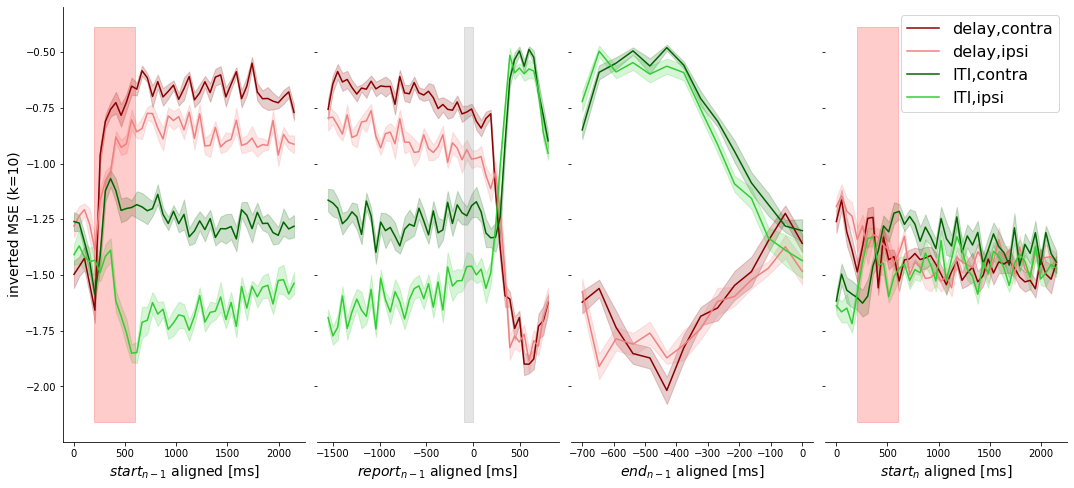

In [175]:
label_delay_ipsi='delay,ipsi'
label_response_ipsi='ITI,ipsi'
label_delay_contra='delay,contra'
label_response_contra='ITI,contra'

plot_hemispheres_delayVSresponse(acc_bias_prev_delay_leftIpsi, std_bias_prev_delay_leftIpsi,\
                               acc_bias_curr_delay_leftIpsi, std_bias_curr_delay_leftIpsi, label_delay_ipsi,\
                                 acc_bias_prev_response_leftIpsi, std_bias_prev_response_leftIpsi,\
                               acc_bias_curr_response_leftIpsi, std_bias_curr_response_leftIpsi,label_response_ipsi,\
                                 acc_bias_prev_delay_leftContra, std_bias_prev_delay_leftContra,\
                               acc_bias_curr_delay_leftContra, std_bias_curr_delay_leftContra, label_delay_contra,\
                                 acc_bias_prev_response_leftContra, std_bias_prev_response_leftContra,\
                               acc_bias_curr_response_leftContra, std_bias_curr_response_leftContra,label_response_contra,\
                                 borders, borders_pastdelay, mode, baseline)

# Determine high/low decoding reactivations to predict serial dependence

In [30]:
mode='MSE'
y = df_serial['target_prev'].values-np.pi#'response_prev'#'target_prev'
acc_reactivations_singletrial = decode_continuous_leave1out_reactivations(df_serial,y,borders_full,mode)
acc_reactivations_singletrial = np.array(acc_reactivations_singletrial)
acc_reactivations_singletrial = np.concatenate(acc_reactivations_singletrial, axis=1)


In [31]:
# use target-prediction difference average across trial start until stimulus start, convert to °
#acc_react_single_avg = np.mean(abs(acc_reactivations_singletrial), axis=1)-np.min(abs(acc_reactivations_singletrial), axis=1)#np.concatenate(np.min(abs(acc_reactivations_singletrial*180/np.pi), axis=0))
trial2_start = borders_full[2]-borders_full[1]
# start at fixation start
react_start = -(trial2_start+int(100/bins))# go back 100ms in time before stimulus start
# end 100ms after stimulus start
react_end = -(trial2_start-int(100/bins))# go until 100ms in time after stimulus start

acc_react_single_avg = np.min(abs(acc_reactivations_singletrial[:, react_start:react_end]), axis=1)

(array([183., 136.,  81.,  63.,  35.,  24.,  10.,   7.,   5.,   2.]),
 array([4.33910649e-04, 2.40928664e-01, 4.81423418e-01, 7.21918172e-01,
        9.62412926e-01, 1.20290768e+00, 1.44340243e+00, 1.68389719e+00,
        1.92439194e+00, 2.16488669e+00, 2.40538145e+00]),
 <a list of 10 Patch objects>)

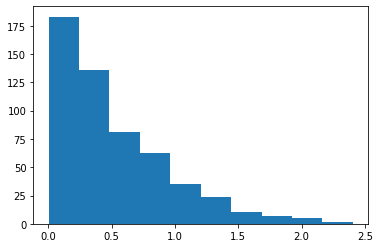

In [32]:
plt.hist(acc_react_single_avg)

In [33]:
np.mean(acc_react_single_avg)

0.5176355193745381

In [34]:
# split into high VS low decoding
cut = np.median(abs(acc_react_single_avg))
#high_decoding_idx = np.where((acc_react_single_avg<cut) & (acc_react_single_avg>-cut))[0]
#low_decoding_idx = np.where((acc_react_single_avg>cut) | (acc_react_single_avg<-cut))[0]
high_decoding_idx = np.where(acc_react_single_avg<cut)[0]
low_decoding_idx = np.where(acc_react_single_avg>cut)[0]

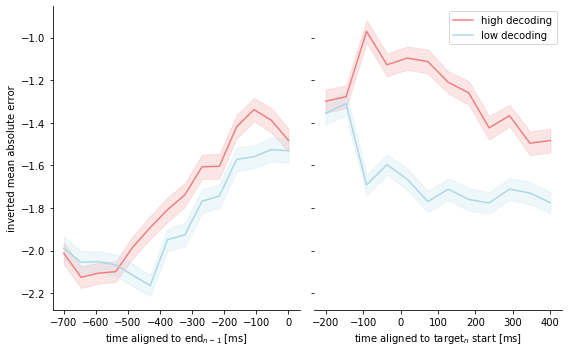

In [42]:
plot_reactivations(acc_reactivations_singletrial, high_decoding_idx, low_decoding_idx, borders_full)

-0.9847718998509625


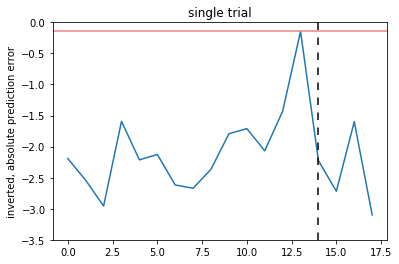

In [202]:
trial=7
plt.plot(abs(acc_reactivations_singletrial[trial,:])*(-1))
plt.axhline(max(abs(acc_reactivations_singletrial[trial, (borders_full[8]-borders_full[7]-5):])*(-1)), color='lightcoral')
plt.axvline(borders_full[8]-borders_full[7], dashes=[5,5], color='k')# end of prev trial
plt.ylim([-3.5,-0])
plt.ylabel('inverted, absolute prediction error')
plt.title('single trial')
print(max(abs(acc_reactivations_singletrial[trial, (borders_full[8]-borders_full[7]-5):]))*(-1)-np.mean(abs(acc_reactivations_singletrial)*(-1), axis=1)[trial]) 

## calculate serial dependence based on high/low decoding

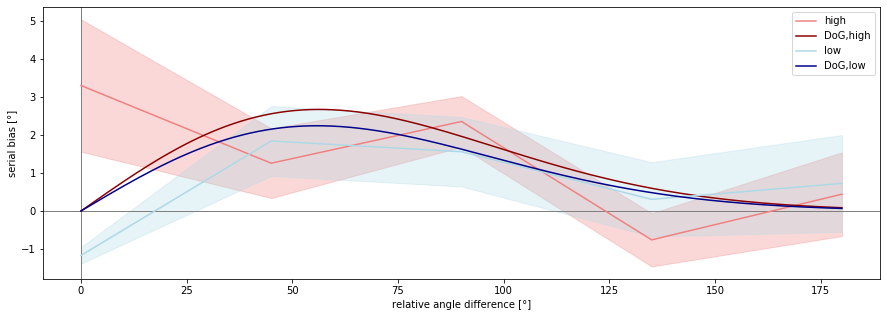

Ttest_indResult(statistic=0.14529623168533146, pvalue=0.8845891324212656)


In [667]:
ttest_single, ttest = serialbias_highVSlow(df_serial.loc[high_decoding_idx], df_serial.loc[low_decoding_idx], 'high', 'low')

## Serial dependence on high/low reactivations for ALL monkeys 

In [23]:
# accuracy (MSE) sorted by monkey from borders[7] prev trial to borders[2] curr trial
acc_react_all, borders_all = read_reactivations_AllMonkeys('../Results/reactivationStrength2cue_AllMonkeys.h5', df_dat, 'single')

<KeysViewHDF5 ['Pe0', 'Pe0_borders', 'Sa0', 'Sa0_borders', 'Sa1', 'Sa1_borders', 'Sa2', 'Sa2_borders', 'Wa0', 'Wa0_borders']>
<HDF5 dataset "Sa0": shape (588, 27), type "<f8">
<HDF5 dataset "Sa1": shape (524, 27), type "<f8">
<HDF5 dataset "Sa2": shape (546, 26), type "<f8">
<HDF5 dataset "Pe0": shape (411, 16), type "<f8">
<HDF5 dataset "Wa0": shape (263, 16), type "<f8">


In [24]:
min_len = min([[(borders_all[mono][sess][1]-borders_all[mono][sess][0])+(borders_all[mono][sess][8]-borders_all[mono][sess][7]) for sess in range(len(borders_all[mono]))] for mono in list(borders_all.keys())])[0]
trial2_start = min([[borders_all[mono][sess][2]-borders_all[mono][sess][1] for sess in range(len(borders_all[mono]))] for mono in list(borders_all.keys())])[0]

# start at fixation start
react_start = -(trial2_start+int(100/bins))# go back 100ms in time before stimulus start
# end 100ms after stimulus start
react_end = -(trial2_start-int(100/bins))# go until 100ms in time after stimulus start

high_decoding_idx_single, low_decoding_idx_single, \
high_decoding_idx_full, low_decoding_idx_full, \
high_trials,low_trials = determine_HighLowTrials(df_dat, acc_react_all, react_start, react_end)

In [25]:
# create list with values needed for serial bias calculation (ONLY if two trials are in a row)
# no need to extra specify sessions, trial_id changes from large # to small #
serial_all = {'trial_id':[], 'target_prev': [], 'response_prev': [], 'delay_prev': [], 'target_curr': [], 'response_curr': [], 'delay_curr': [], 'monkey': [], 'session':[]}
for idx in df_dat.index[:-1]:
    if ((df_dat['trial_id'][idx]+1) == (df_dat['trial_id'][idx+1])):
        serial_all['trial_id'].append(idx)
        serial_all['target_prev'].append(df_dat['targ_angle'][idx]*np.pi/180)
        serial_all['response_prev'].append(df_dat['saccade_angle'][idx]*np.pi/180)
        serial_all['delay_prev'].append(df_dat['go_cue'][idx]-df_dat['targ_off'][idx])
        serial_all['target_curr'].append(df_dat['targ_angle'][idx+1]*np.pi/180)
        serial_all['response_curr'].append(df_dat['saccade_angle'][idx+1]*np.pi/180)
        serial_all['delay_curr'].append(df_dat['go_cue'][idx+1]-df_dat['targ_off'][idx+1]) 
        serial_all['monkey'].append(df_dat['monkey'][idx])
        serial_all['session'].append(df_dat['session'][idx])

df_serial_all = pd.DataFrame(serial_all)

# Compute serial dependence
rel_loc_all, err_all = calc_errorcurve(df_serial_all)
        
sb_all = {'rel_loc': rel_loc_all*180/np.pi, 'err': err_all*180/np.pi, 'delay_prev': serial_all['delay_prev'],\
      'delay_curr': serial_all['delay_curr'], 'monkey': serial_all['monkey']}
df_sb_all = pd.DataFrame(sb_all)

sb_onesided_all = {'rel_loc': rel_loc_all*180/np.pi*np.sign(rel_loc_all),\
               'err': np.array([err_all[i]*180/np.pi*np.sign(rel_loc_all[i]) if rel_loc_all[i] !=0 else err_all[i]*180/np.pi for i in range(len(rel_loc_all))]),\
               'delay_prev': serial_all['delay_prev'], 'delay_curr': serial_all['delay_curr'], 'monkey': serial_all['monkey']}
df_sb_onesided_all = pd.DataFrame(sb_onesided_all)



single session reactivation time course

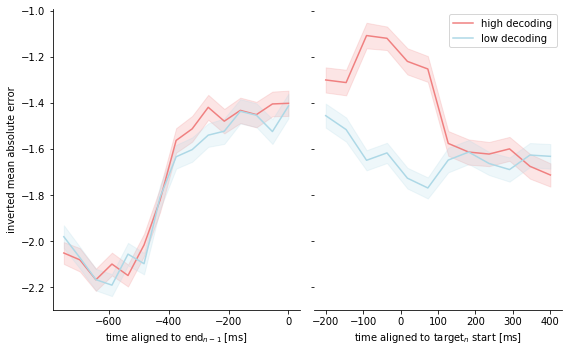

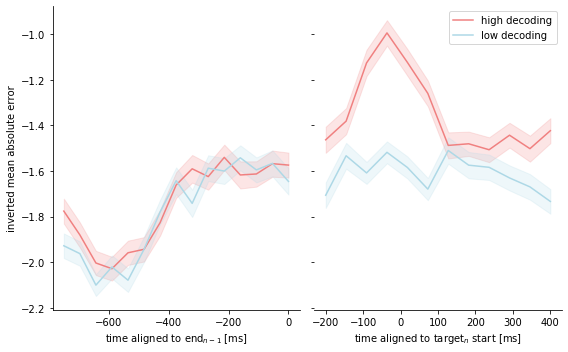

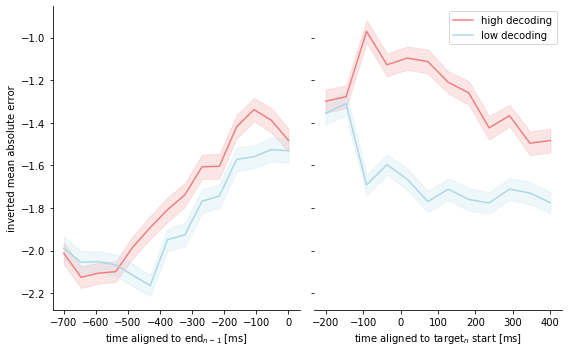

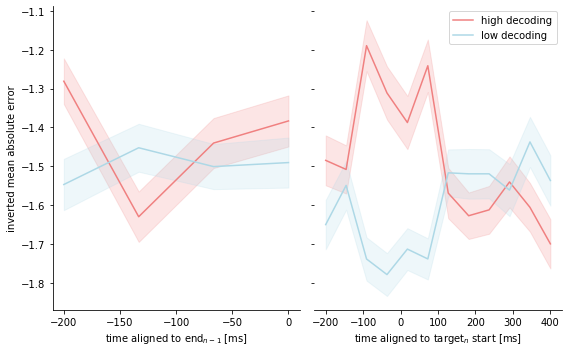

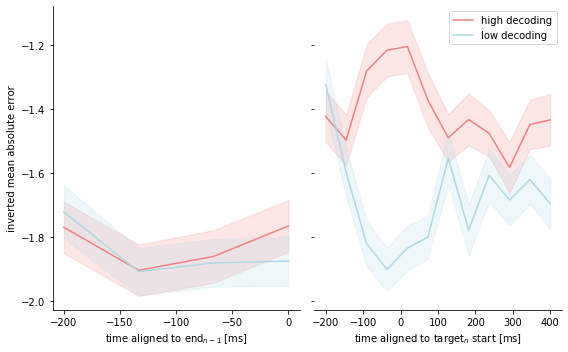

In [26]:
hep=0
#plt.figure()
for mono in ['Sa', 'Pe', 'Wa']:
    for sess in range(max(df_dat.loc[df_dat.monkey==mono].session)+1):
        # borders differ across sessions
        plot_reactivations(acc_react_all[mono][sess], high_decoding_idx_single[hep].astype(int),\
                           low_decoding_idx_single[hep].astype(int), borders_all[mono][sess])
        hep+=1

In [27]:
# combine borders for all sessions, trials
borders_append = np.concatenate([[borders_all[mono][sess] for sess in range(len(borders_all[mono]))] for mono in borders_all.keys()]) 
min_trial_end = min(borders_append[:,8]-borders_append[:,7])
min_fix = min(borders_append[:,1]-borders_append[:,0])

In [28]:
high_trials_concat = [high_trials[mono][sess] for sess in range(len(high_trials[mono])) for mono in high_trials.keys()]

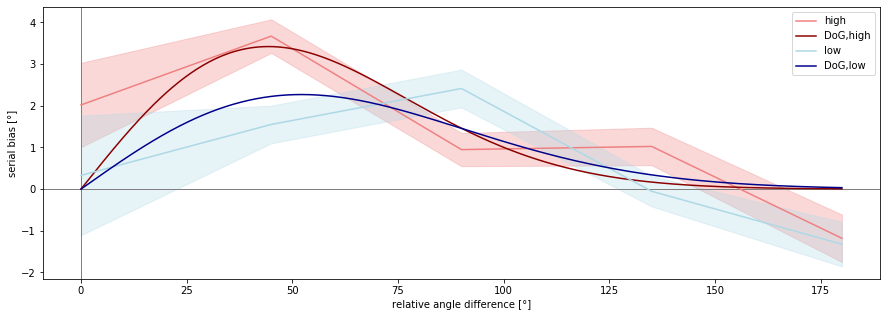

Ttest_indResult(statistic=2.4625803889421247, pvalue=0.013895286512727194)


In [29]:
high = np.concatenate(high_decoding_idx_full[0:3])# 0:3 = Sa
low = np.concatenate(low_decoding_idx_full[0:3])# 0:3 = Sa

ttest_single, ttest = serialbias_highVSlow(df_serial_all.loc[high], df_serial_all.loc[low], 'high', 'low')

# Serial depedence on high/low, ipsi vs contra

In [30]:
# accuracy (MSE) sorted by monkey
acc_react_all_IC, _ = read_reactivations_AllMonkeys('../Results/reactivationStrength_AllMonkeys_IpsiContra.h5', df_dat, 'hemispheres')

<KeysViewHDF5 ['Pe0_leftContra', 'Pe0_leftIpsi', 'Pe0_rightContra', 'Pe0_rightIpsi', 'Sa0_leftContra', 'Sa0_leftIpsi', 'Sa0_rightContra', 'Sa0_rightIpsi', 'Sa1_leftContra', 'Sa1_leftIpsi', 'Sa1_rightContra', 'Sa1_rightIpsi', 'Sa2_leftContra', 'Sa2_leftIpsi', 'Sa2_rightContra', 'Sa2_rightIpsi', 'Wa0_leftContra', 'Wa0_leftIpsi', 'Wa0_rightContra', 'Wa0_rightIpsi']>
<HDF5 dataset "Sa0_leftIpsi": shape (288, 19), type "<f8">
<HDF5 dataset "Sa0_leftContra": shape (300, 19), type "<f8">
<HDF5 dataset "Sa0_rightIpsi": shape (300, 19), type "<f8">
<HDF5 dataset "Sa0_rightContra": shape (288, 19), type "<f8">
<HDF5 dataset "Sa1_leftIpsi": shape (257, 19), type "<f8">
<HDF5 dataset "Sa1_leftContra": shape (267, 19), type "<f8">
<HDF5 dataset "Sa1_rightIpsi": shape (267, 19), type "<f8">
<HDF5 dataset "Sa1_rightContra": shape (257, 19), type "<f8">
<HDF5 dataset "Sa2_leftIpsi": shape (346, 18), type "<f8">
<HDF5 dataset "Sa2_leftContra": shape (346, 18), type "<f8">
<HDF5 dataset "Sa2_rightIpsi":

In [31]:
targ_left = np.where((df_serial_all['target_prev']>=np.pi/2) & (df_serial_all['target_prev']<=np.pi+np.pi/2))[0]
targ_right = np.where((df_serial_all['target_prev']<=np.pi/2) | (df_serial_all['target_prev']>=np.pi+np.pi/2))[0]

Decode high vs low decoding trials

In [32]:
acc_leftIpsi = {'Sa':acc_react_all_IC['Sa_leftIpsi'], 'Pe':acc_react_all_IC['Pe_leftIpsi'], 'Wa':acc_react_all_IC['Wa_leftIpsi']}
acc_leftContra = {'Sa':acc_react_all_IC['Sa_leftContra'], 'Pe':acc_react_all_IC['Pe_leftContra'], 'Wa':acc_react_all_IC['Wa_leftContra']}
acc_rightIpsi = {'Sa':acc_react_all_IC['Sa_rightIpsi'], 'Pe':acc_react_all_IC['Pe_rightIpsi'], 'Wa':acc_react_all_IC['Wa_rightIpsi']}
acc_rightContra = {'Sa':acc_react_all_IC['Sa_rightContra'], 'Pe':acc_react_all_IC['Pe_rightContra'], 'Wa':acc_react_all_IC['Wa_rightContra']}

high_decoding_idx_single_leftIpsi, low_decoding_idx_single_leftIpsi, \
high_decoding_idx_full_leftIpsi, low_decoding_idx_full_leftIpsi, \
high_trials,low_trials_leftIpsi = determine_HighLowTrials(df_dat, acc_leftIpsi, react_start, react_end)

high_decoding_idx_single_leftContra, low_decoding_idx_single_leftContra, \
high_decoding_idx_full_leftContra, low_decoding_idx_full_leftContra, \
high_trials,low_trials_leftContra = determine_HighLowTrials(df_dat, acc_leftContra, react_start, react_end)

high_decoding_idx_single_rightIpsi, low_decoding_idx_single_rightIpsi, \
high_decoding_idx_full_rightIpsi, low_decoding_idx_full_rightIpsi, \
high_trials,low_trials_rightIpsi = determine_HighLowTrials(df_dat, acc_rightIpsi, react_start, react_end)

high_decoding_idx_single_rightContra, low_decoding_idx_single_rightContra, \
high_decoding_idx_full_rightContra, low_decoding_idx_full_rightContra, \
high_trials,low_trials_rightContra = determine_HighLowTrials(df_dat, acc_rightContra, react_start, react_end)

Correlate decoder error for left vs right neurons (reactivations at same time points)

In [33]:
len(acc_leftIpsi['Wa'][0][0])

8

In [34]:
acc_leftIpsi[mono][sess][:,-(timing+1):-timing]

NameError: name 'timing' is not defined

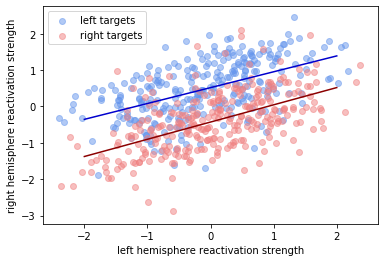

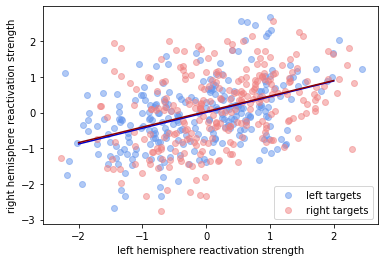

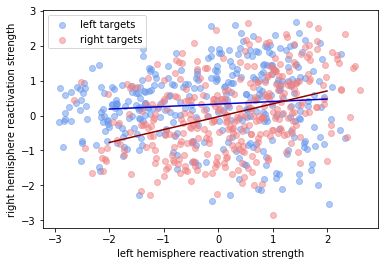

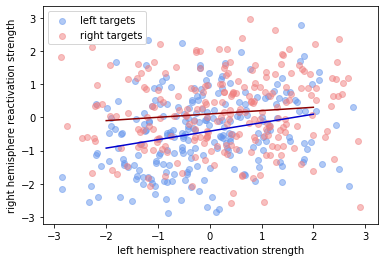

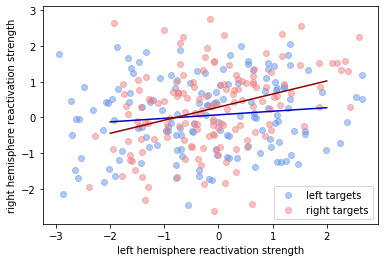

In [35]:
r2_left=[]
r2_right=[]
for mono in acc_leftIpsi.keys():
    for sess in range(len(acc_leftIpsi[mono])):
        r2_l=[]
        r2_r=[]
        for timing in range(min_len-1):
            # determine r² score
            #left
            if timing==0:
                dat ={'x': acc_leftIpsi[mono][sess][:,-(timing+1):], 'y':acc_rightContra[mono][sess][:,-(timing+1):]}                
            else:
                dat ={'x': acc_leftIpsi[mono][sess][:,-(timing+1):-timing], 'y':acc_rightContra[mono][sess][:,-(timing+1):-timing]}
            mod=sf.ols('y~x',data=dat)
            res_left=mod.fit()
            r2_l.append(res_left.rsquared)
            #right
            if timing==0:
                dat ={'x': acc_leftContra[mono][sess][:,-(timing+1):], 'y':acc_rightIpsi[mono][sess][:,-(timing+1):]}                
            else:
                dat ={'x': acc_leftContra[mono][sess][:,-(timing+1):-timing], 'y':acc_rightIpsi[mono][sess][:,-(timing+1):-timing]}
            mod=sf.ols('y~x',data=dat)
            res_right=mod.fit()
            r2_r.append(res_right.rsquared)
        r2_left.append(r2_l)
        r2_right.append(r2_r)
        
        r2_left = r2_left[::-1]
        r2_right = r2_right[::-1]
        # determine linear fit
        params_left = LinearRegression().fit(np.mean(acc_leftIpsi[mono][sess][:,react_start:react_end], axis=1).reshape(-1,1), np.mean(acc_rightContra[mono][sess][:,react_start:react_end], axis=1).reshape(-1,1))
        params_right = LinearRegression().fit(np.mean(acc_leftContra[mono][sess][:,react_start:react_end], axis=1).reshape(-1,1), np.mean(acc_rightIpsi[mono][sess][:,react_start:react_end], axis=1).reshape(-1,1))
        
        x_ang=np.linspace(-2,2,50)
        plt.figure()
        plt.scatter(np.mean(acc_leftIpsi[mono][sess][:,react_start:react_end], axis=1), np.mean(acc_rightContra[mono][sess][:,react_start:react_end], axis=1), color='cornflowerblue', alpha=0.5, label='left targets')
        plt.scatter(np.mean(acc_leftContra[mono][sess][:,react_start:react_end], axis=1), np.mean(acc_rightIpsi[mono][sess][:,react_start:react_end], axis=1), color='lightcoral', alpha=0.5, label='right targets')
        plt.plot(x_ang, params_left.coef_[0]*x_ang+params_left.intercept_[0], color='mediumblue',)
        plt.plot(x_ang, params_right.coef_[0]*x_ang+params_right.intercept_[0], color='darkred',)
        plt.xlabel('left hemisphere reactivation strength')
        plt.ylabel('right hemisphere reactivation strength')
        plt.legend()
        plt.show()


In [136]:
r2_left[0]

[0.007315333587205708,
 0.00034557547250735343,
 0.0065607750179979,
 0.00056665275322898,
 1.7307011742961897e-05,
 0.008100411945706876,
 0.040877171604912]

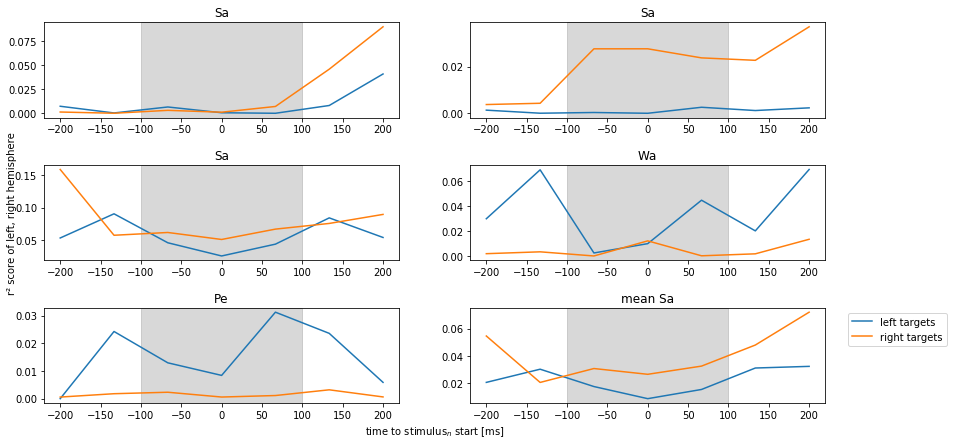

In [169]:
x = np.linspace(-min_trial_end*bins, min_fix*bins, len(r2_left[0]))
fig = plt.figure(figsize=(14,7))
plt.subplots_adjust(hspace=0.5)
for i in range(len(r2_left)):
    plt.subplot(3,2,i+1)
    plt.plot(x, r2_left[i], label='left targets')
    plt.plot(x, r2_right[i], label='right targets')
    plt.axvspan(-100,100, color='grey', alpha=0.3)
    #plt.xlabel('time to stimulus$_n$ start [ms]')
    #plt.ylabel('r² score of left, right hemisphere')
    if i<3:
        plt.title('Sa')
    elif i==4:
        plt.title('Pe')
    else:
        plt.title('Wa')
    #plt.legend()
    
plt.subplot(3,2,6)
plt.plot(x, np.mean(r2_left[0:3], axis=0), label='left targets')
plt.plot(x, np.mean(r2_right[0:3], axis=0), label='right targets')
plt.axvspan(-100,100, color='grey', alpha=0.3)
plt.title('mean Sa')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('time to stimulus$_n$ start [ms]')
plt.ylabel('r² score of left, right hemisphere')
#plt.savefig('../Figures/Neural/SerialBias/hemispheres/correlation/CorrelationLeftRightHemisphere_splitLeftRightTargets_allMonkeys.png', dpi=100)
plt.show()

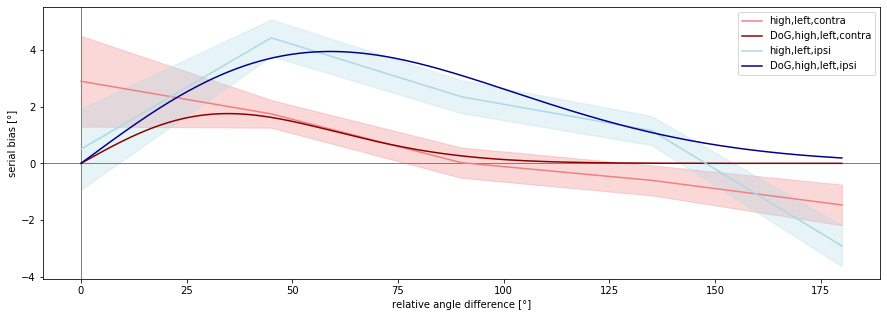

Ttest_indResult(statistic=-3.915567136263218, pvalue=9.701329752695602e-05)


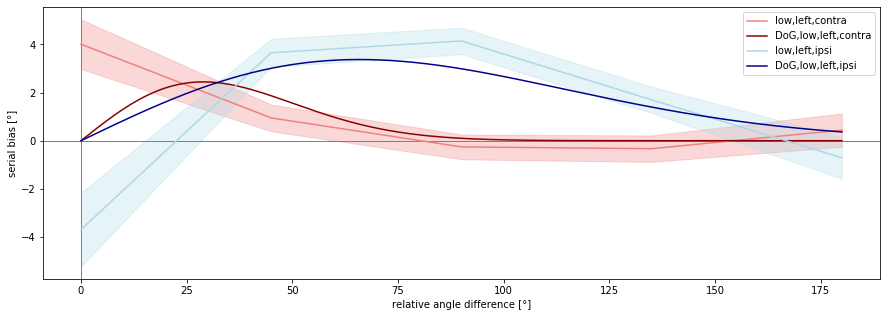

Ttest_indResult(statistic=-3.015214327898567, pvalue=0.0026399979385726916)


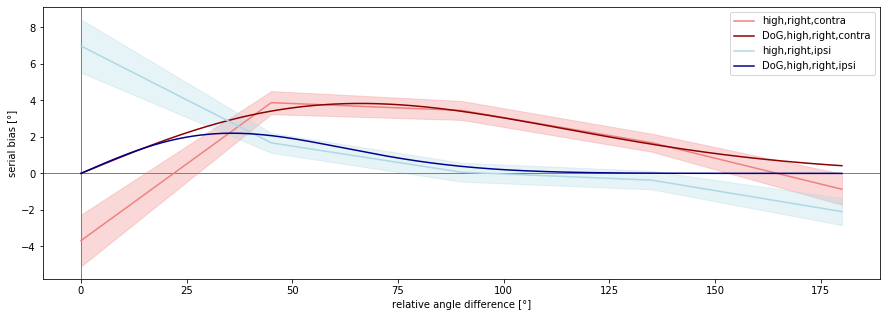

Ttest_indResult(statistic=3.8407241162746226, pvalue=0.00013127969757957151)


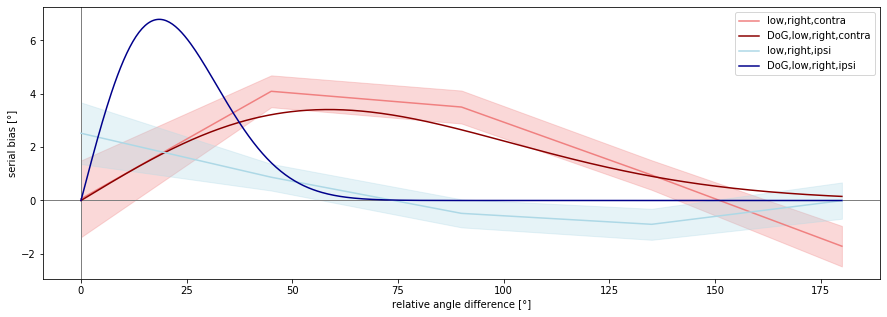

Ttest_indResult(statistic=3.0911404405602747, pvalue=0.002055200899768692)


In [73]:
m_idx1 = 0
m_idx2 = 3
df_left = df_serial_all.loc[targ_left].reset_index()
df_right = df_serial_all.loc[targ_right].reset_index()

## high, left, ipsi contra
hli = np.concatenate(high_decoding_idx_full_leftIpsi[m_idx1:m_idx2]).astype(int)# 0:3 = Sa
hlc = np.concatenate(high_decoding_idx_full_leftContra[m_idx1:m_idx2]).astype(int)# 0:3 = Sa

ttest_single, ttest = serialbias_highVSlow(df_right.loc[hlc], df_left.loc[hli], 'high,left,contra', 'high,left,ipsi')

## low, left, ipsi contra
lli = np.concatenate(low_decoding_idx_full_leftIpsi[m_idx1:m_idx2]).astype(int)# 0:3 = Sa
llc = np.concatenate(low_decoding_idx_full_leftContra[m_idx1:m_idx2]).astype(int)# 0:3 = Sa

ttest_single, ttest = serialbias_highVSlow(df_right.loc[llc], df_left.loc[lli],  'low,left,contra', 'low,left,ipsi')

## high, right, ipsi contra
hri = np.concatenate(high_decoding_idx_full_rightIpsi[m_idx1:m_idx2]).astype(int)# 0:3 = Sa
hrc = np.concatenate(high_decoding_idx_full_rightContra[m_idx1:m_idx2]).astype(int)# 0:3 = Sa

ttest_single, ttest = serialbias_highVSlow(df_left.loc[hrc], df_right.loc[hri], 'high,right,contra', 'high,right,ipsi')

## low, right, ipsi contra
lri = np.concatenate(low_decoding_idx_full_rightIpsi[m_idx1:m_idx2]).astype(int)# 0:3 = Sa
lrc = np.concatenate(low_decoding_idx_full_rightContra[m_idx1:m_idx2]).astype(int)# 0:3 = Sa

ttest_single, ttest = serialbias_highVSlow(df_left.loc[lrc], df_right.loc[lri], 'low,right,contra', 'low,right,ipsi')





high contralateral vs high ipsilateral, across hemispheres

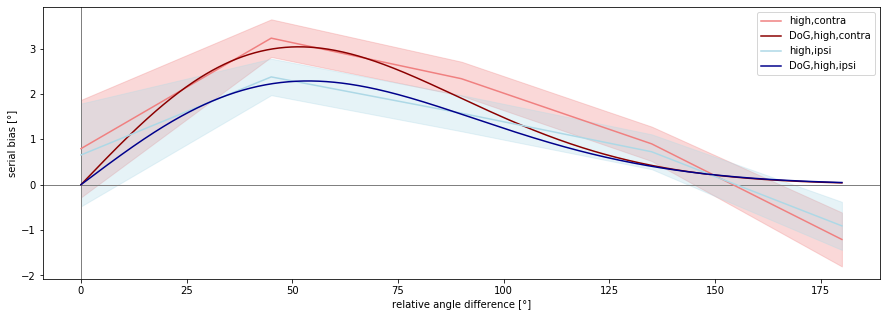

Ttest_indResult(statistic=1.0908671328077202, pvalue=0.27547735199308243)


In [765]:
hi = np.append(hli,hri)
hc = np.append(hlc,hrc)
ttest_single, ttest = serialbias_highVSlow(df_left.loc[hrc].append(df_right.loc[hlc]), df_right.loc[hri].append(df_left.loc[hli]), 'high,contra', 'high,ipsi')


## Previous and current trial on same/opposite hemispheres

In [64]:
targ_ll = np.where(((df_serial_all['target_prev']>=np.pi/2) & (df_serial_all['target_prev']<=np.pi+np.pi/2)) & ((df_serial_all['target_curr']>=np.pi/2) & (df_serial_all['target_curr']<=np.pi+np.pi/2)))[0]
targ_rr = np.where(((df_serial_all['target_prev']<=np.pi/2) | (df_serial_all['target_prev']>=np.pi+np.pi/2)) & ((df_serial_all['target_curr']<=np.pi/2) | (df_serial_all['target_curr']>=np.pi+np.pi/2)))[0]

In [817]:
df_right.loc[hlc].loc[(df_serial_all['target_curr']<=np.pi/2) | (df_serial_all['target_curr']>=np.pi+np.pi/2)]

,index,trial_id,target_prev,response_prev,delay_prev,target_curr,response_curr,delay_curr,monkey,session
0,4,5,0.392699,0.480116,3029,5.105088,4.924333,1931,Sa,0
5,9,11,0.392699,0.498078,1930,3.534292,3.575747,2830,Sa,0
6,13,16,5.890486,5.706430,2030,1.963495,2.024880,2630,Sa,0
7,15,18,0.392699,0.318224,2230,2.748894,2.835051,2120,Sa,0
12,24,29,0.392699,0.400830,1529,5.105088,4.974092,2630,Sa,0
...,...,...,...,...,...,...,...,...,...,...
1268,2283,3532,0.392699,0.353448,1918,1.963495,1.898034,1918,Wa,0
1281,2306,3565,0.000000,6.237796,1918,2.356194,2.318866,2018,Wa,0
1286,2314,3573,1.570796,1.462571,1519,1.178097,1.129622,2018,Wa,0
1291,2325,3586,0.785398,0.789269,1719,3.141593,3.155639,1718,Wa,0


In [822]:
np.where(hli == targ_ll)

/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


(array([], dtype=int64),)

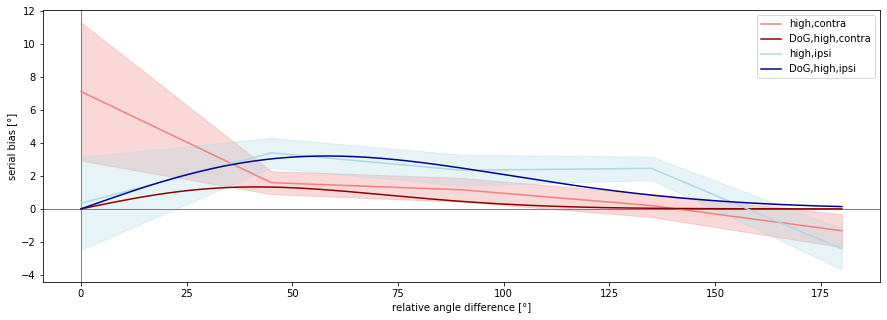

Ttest_indResult(statistic=-2.0965672743327817, pvalue=0.03661425612070652)


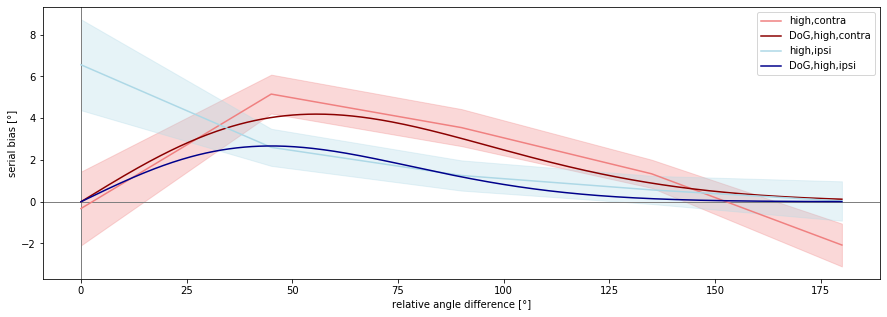

Ttest_indResult(statistic=0.9581793494766586, pvalue=0.33849495752891856)


In [59]:
#df_ll = df_left.loc[np.where((df_serial_all['target_curr']>=np.pi/2) & (df_serial_all['target_curr']<=np.pi+np.pi/2))[0]]
#df_rr = df_serial_all.loc[targ_rr]

## high, left, ipsi contra
hli = np.concatenate(high_decoding_idx_full_leftIpsi[m_idx1:m_idx2]).astype(int)# 0:3 = Sa #
#bool_hli =[True if (hli==n).any() else False for n in range(len(targ_ll))]
hlc = np.concatenate(high_decoding_idx_full_leftContra[m_idx1:m_idx2]).astype(int)# 0:3 = Sa
#bool_hlc =[True if (hlc==n).any() else False for n in range(len(targ_ll))]
hri = np.concatenate(high_decoding_idx_full_rightIpsi[m_idx1:m_idx2]).astype(int)# 0:3 = Sa #
#bool_hli =[True if (hli==n).any() else False for n in range(len(targ_ll))]
hrc = np.concatenate(high_decoding_idx_full_rightContra[m_idx1:m_idx2]).astype(int)# 0:3 = Sa


ttest_single, ttest = serialbias_highVSlow(df_right.loc[hlc].loc[(df_serial_all['target_curr']<=np.pi/2) | (df_serial_all['target_curr']>=np.pi+np.pi/2)], df_left.loc[hli].loc[(df_serial_all['target_curr']>=np.pi/2) & (df_serial_all['target_curr']<=np.pi+np.pi/2)], 'high,contra', 'high,ipsi')

ttest_single, ttest = serialbias_highVSlow(df_left.loc[hrc].loc[(df_serial_all['target_curr']>=np.pi/2) & (df_serial_all['target_curr']<=np.pi+np.pi/2)], df_right.loc[hri].loc[(df_serial_all['target_curr']<=np.pi/2) | (df_serial_all['target_curr']>=np.pi+np.pi/2)], 'high,contra', 'high,ipsi')


In [62]:
len(df_ll)

NameError: name 'df_ll' is not defined

In [85]:
df_ll = df_serial_all.loc[targ_ll]

len(df_left.loc[(df_left['monkey']=='Sa') & (df_left['session']==1)])

257

In [86]:
df_rr = df_serial_all.loc[targ_rr]
len(df_right.loc[(df_right['monkey']=='Sa') & (df_right['session']==1)])

267